##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
!pip install -q tf-nightly

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 4202496/68606236 [>.............................] - ETA: 18s

20029440/68606236 [=======>......................] - ETA: 3s 

33562624/68606236 [=============>................] - ETA: 1s

50511872/68606236 [=====================>........] - ETA: 0s

68108288/68606236 [============================>.] - ETA: 0s

68608000/68606236 [==============================] - 2s 0us/step


Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

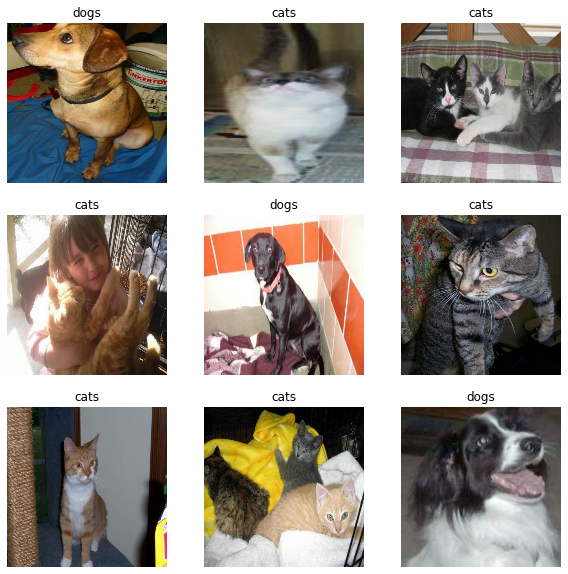

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

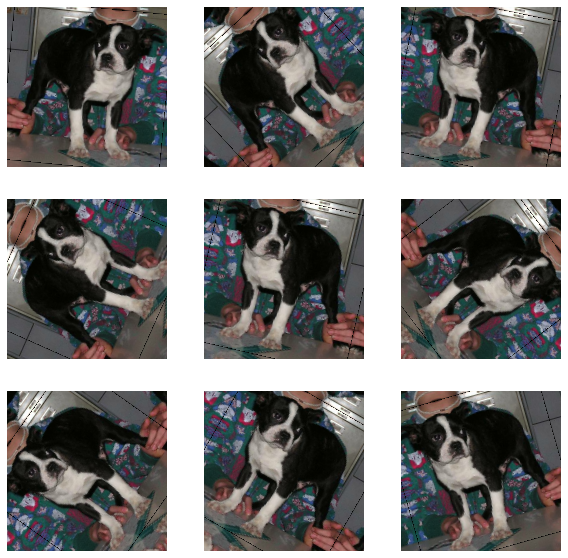

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [17]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [24]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 44s - loss: 0.8243 - accuracy: 0.4688

 2/26 [=>............................] - ETA: 3s - loss: 0.7916 - accuracy: 0.5078 

 3/26 [==>...........................] - ETA: 3s - loss: 0.7955 - accuracy: 0.4948

 4/26 [===>..........................] - ETA: 3s - loss: 0.7915 - accuracy: 0.4863

 5/26 [====>.........................] - ETA: 3s - loss: 0.7884 - accuracy: 0.4816

 6/26 [=====>........................] - ETA: 3s - loss: 0.7882 - accuracy: 0.4794

 7/26 [=======>......................] - ETA: 3s - loss: 0.7905 - accuracy: 0.4741

 8/26 [========>.....................] - ETA: 2s - loss: 0.7907 - accuracy: 0.4715

 9/26 [=========>....................] - ETA: 2s - loss: 0.7894 - accuracy: 0.4712

10/26 [==========>...................] - ETA: 2s - loss: 0.7875 - accuracy: 0.4712

11/26 [===========>..................] - ETA: 2s - loss: 0.7865 - accuracy: 0.4707

12/26 [============>.................] - ETA: 2s - loss: 0.7857 - accuracy: 0.4712

13/26 [==============>...............] - ETA: 2s - loss: 0.7858 - accuracy: 0.4714

14/26 [===============>..............] - ETA: 1s - loss: 0.7858 - accuracy: 0.4712

15/26 [================>.............] - ETA: 1s - loss: 0.7860 - accuracy: 0.4711

16/26 [=================>............] - ETA: 1s - loss: 0.7864 - accuracy: 0.4707

17/26 [==================>...........] - ETA: 1s - loss: 0.7870 - accuracy: 0.4702

18/26 [===================>..........] - ETA: 1s - loss: 0.7876 - accuracy: 0.4697

19/26 [====================>.........] - ETA: 1s - loss: 0.7880 - accuracy: 0.4688

20/26 [======================>.......] - ETA: 0s - loss: 0.7885 - accuracy: 0.4681

21/26 [=======================>......] - ETA: 0s - loss: 0.7890 - accuracy: 0.4674

22/26 [========================>.....] - ETA: 0s - loss: 0.7896 - accuracy: 0.4669

23/26 [=========================>....] - ETA: 0s - loss: 0.7898 - accuracy: 0.4666

24/26 [==========================>...] - ETA: 0s - loss: 0.7898 - accuracy: 0.4668

25/26 [===========================>..] - ETA: 0s - loss: 0.7897 - accuracy: 0.4671

26/26 [==============================] - 6s 150ms/step - loss: 0.7895 - accuracy: 0.4676


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.47


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:35 - loss: 0.8307 - accuracy: 0.5312

 2/63 [..............................] - ETA: 10s - loss: 0.8421 - accuracy: 0.5000 

 3/63 [>.............................] - ETA: 10s - loss: 0.8662 - accuracy: 0.4792

 4/63 [>.............................] - ETA: 10s - loss: 0.8949 - accuracy: 0.4688

 5/63 [=>............................] - ETA: 9s - loss: 0.8989 - accuracy: 0.4938 

 6/63 [=>............................] - ETA: 9s - loss: 0.8665 - accuracy: 0.5104

 7/63 [==>...........................] - ETA: 9s - loss: 0.8616 - accuracy: 0.5089

 8/63 [==>...........................] - ETA: 9s - loss: 0.8664 - accuracy: 0.5117

 9/63 [===>..........................] - ETA: 9s - loss: 0.8725 - accuracy: 0.5104

10/63 [===>..........................] - ETA: 9s - loss: 0.8773 - accuracy: 0.5031

11/63 [====>.........................] - ETA: 9s - loss: 0.8593 - accuracy: 0.5170

12/63 [====>.........................] - ETA: 8s - loss: 0.8542 - accuracy: 0.5182

13/63 [=====>........................] - ETA: 8s - loss: 0.8399 - accuracy: 0.5240

14/63 [=====>........................] - ETA: 8s - loss: 0.8492 - accuracy: 0.5112

15/63 [======>.......................] - ETA: 8s - loss: 0.8398 - accuracy: 0.5167

16/63 [======>.......................] - ETA: 8s - loss: 0.8436 - accuracy: 0.5195

17/63 [=======>......................] - ETA: 8s - loss: 0.8499 - accuracy: 0.5184

18/63 [=======>......................] - ETA: 7s - loss: 0.8504 - accuracy: 0.5191

19/63 [========>.....................] - ETA: 7s - loss: 0.8461 - accuracy: 0.5181

20/63 [========>.....................] - ETA: 7s - loss: 0.8465 - accuracy: 0.5125

21/63 [=========>....................] - ETA: 7s - loss: 0.8403 - accuracy: 0.5134

22/63 [=========>....................] - ETA: 7s - loss: 0.8378 - accuracy: 0.5213

23/63 [=========>....................] - ETA: 6s - loss: 0.8342 - accuracy: 0.5190

24/63 [==========>...................] - ETA: 6s - loss: 0.8279 - accuracy: 0.5208

25/63 [==========>...................] - ETA: 6s - loss: 0.8256 - accuracy: 0.5175

26/63 [===========>..................] - ETA: 6s - loss: 0.8198 - accuracy: 0.5228

27/63 [===========>..................] - ETA: 6s - loss: 0.8155 - accuracy: 0.5208

28/63 [============>.................] - ETA: 6s - loss: 0.8130 - accuracy: 0.5212

29/63 [============>.................] - ETA: 5s - loss: 0.8083 - accuracy: 0.5226

30/63 [=============>................] - ETA: 5s - loss: 0.8020 - accuracy: 0.5250

31/63 [=============>................] - ETA: 5s - loss: 0.7985 - accuracy: 0.5272

32/63 [==============>...............] - ETA: 5s - loss: 0.7943 - accuracy: 0.5303

33/63 [==============>...............] - ETA: 5s - loss: 0.7879 - accuracy: 0.5331

34/63 [===============>..............] - ETA: 4s - loss: 0.7822 - accuracy: 0.5368

35/63 [===============>..............] - ETA: 4s - loss: 0.7786 - accuracy: 0.5411

36/63 [================>.............] - ETA: 4s - loss: 0.7758 - accuracy: 0.5451

37/63 [================>.............] - ETA: 4s - loss: 0.7724 - accuracy: 0.5456

38/63 [=================>............] - ETA: 4s - loss: 0.7670 - accuracy: 0.5493

39/63 [=================>............] - ETA: 4s - loss: 0.7687 - accuracy: 0.5481

40/63 [==================>...........] - ETA: 3s - loss: 0.7636 - accuracy: 0.5508

41/63 [==================>...........] - ETA: 3s - loss: 0.7638 - accuracy: 0.5495

42/63 [===================>..........] - ETA: 3s - loss: 0.7604 - accuracy: 0.5506

43/63 [===================>..........] - ETA: 3s - loss: 0.7581 - accuracy: 0.5531

44/63 [===================>..........] - ETA: 3s - loss: 0.7547 - accuracy: 0.5554

45/63 [====================>.........] - ETA: 3s - loss: 0.7536 - accuracy: 0.5556

46/63 [====================>.........] - ETA: 2s - loss: 0.7504 - accuracy: 0.5564

47/63 [=====================>........] - ETA: 2s - loss: 0.7472 - accuracy: 0.5572

48/63 [=====================>........] - ETA: 2s - loss: 0.7457 - accuracy: 0.5566

49/63 [======================>.......] - ETA: 2s - loss: 0.7449 - accuracy: 0.5580

50/63 [======================>.......] - ETA: 2s - loss: 0.7437 - accuracy: 0.5562

51/63 [=======================>......] - ETA: 2s - loss: 0.7404 - accuracy: 0.5570

52/63 [=======================>......] - ETA: 1s - loss: 0.7374 - accuracy: 0.5589

53/63 [========================>.....] - ETA: 1s - loss: 0.7359 - accuracy: 0.5601

54/63 [========================>.....] - ETA: 1s - loss: 0.7328 - accuracy: 0.5642

55/63 [=========================>....] - ETA: 1s - loss: 0.7290 - accuracy: 0.5653

56/63 [=========================>....] - ETA: 1s - loss: 0.7295 - accuracy: 0.5631

57/63 [==========================>...] - ETA: 1s - loss: 0.7279 - accuracy: 0.5641

58/63 [==========================>...] - ETA: 0s - loss: 0.7253 - accuracy: 0.5652

59/63 [===========================>..] - ETA: 0s - loss: 0.7241 - accuracy: 0.5651

60/63 [===========================>..] - ETA: 0s - loss: 0.7215 - accuracy: 0.5672

61/63 [============================>.] - ETA: 0s - loss: 0.7199 - accuracy: 0.5686

62/63 [============================>.] - ETA: 0s - loss: 0.7176 - accuracy: 0.5721

63/63 [==============================] - ETA: 0s - loss: 0.7165 - accuracy: 0.5715

63/63 [==============================] - 17s 236ms/step - loss: 0.7165 - accuracy: 0.5715 - val_loss: 0.5602 - val_accuracy: 0.6337


Epoch 2/10


 1/63 [..............................] - ETA: 27s - loss: 0.5258 - accuracy: 0.7188

 2/63 [..............................] - ETA: 10s - loss: 0.5855 - accuracy: 0.7344

 3/63 [>.............................] - ETA: 10s - loss: 0.6136 - accuracy: 0.7083

 4/63 [>.............................] - ETA: 10s - loss: 0.5855 - accuracy: 0.7031

 5/63 [=>............................] - ETA: 9s - loss: 0.5849 - accuracy: 0.6625 

 6/63 [=>............................] - ETA: 9s - loss: 0.5825 - accuracy: 0.6771

 7/63 [==>...........................] - ETA: 9s - loss: 0.5694 - accuracy: 0.6920

 8/63 [==>...........................] - ETA: 9s - loss: 0.5671 - accuracy: 0.6797

 9/63 [===>..........................] - ETA: 9s - loss: 0.5545 - accuracy: 0.6840

10/63 [===>..........................] - ETA: 9s - loss: 0.5515 - accuracy: 0.6906

11/63 [====>.........................] - ETA: 8s - loss: 0.5598 - accuracy: 0.6932

12/63 [====>.........................] - ETA: 8s - loss: 0.5533 - accuracy: 0.6979

13/63 [=====>........................] - ETA: 8s - loss: 0.5555 - accuracy: 0.6947

14/63 [=====>........................] - ETA: 8s - loss: 0.5518 - accuracy: 0.6987

15/63 [======>.......................] - ETA: 8s - loss: 0.5561 - accuracy: 0.6875

16/63 [======>.......................] - ETA: 8s - loss: 0.5525 - accuracy: 0.6875

17/63 [=======>......................] - ETA: 7s - loss: 0.5557 - accuracy: 0.6820

18/63 [=======>......................] - ETA: 7s - loss: 0.5571 - accuracy: 0.6753

19/63 [========>.....................] - ETA: 7s - loss: 0.5584 - accuracy: 0.6793

20/63 [========>.....................] - ETA: 7s - loss: 0.5621 - accuracy: 0.6750

21/63 [=========>....................] - ETA: 7s - loss: 0.5557 - accuracy: 0.6771

22/63 [=========>....................] - ETA: 7s - loss: 0.5538 - accuracy: 0.6804

23/63 [=========>....................] - ETA: 6s - loss: 0.5568 - accuracy: 0.6821

24/63 [==========>...................] - ETA: 6s - loss: 0.5625 - accuracy: 0.6784

25/63 [==========>...................] - ETA: 6s - loss: 0.5636 - accuracy: 0.6750

26/63 [===========>..................] - ETA: 6s - loss: 0.5602 - accuracy: 0.6755

27/63 [===========>..................] - ETA: 6s - loss: 0.5608 - accuracy: 0.6736

28/63 [============>.................] - ETA: 6s - loss: 0.5564 - accuracy: 0.6786

29/63 [============>.................] - ETA: 5s - loss: 0.5542 - accuracy: 0.6810

30/63 [=============>................] - ETA: 5s - loss: 0.5550 - accuracy: 0.6812

31/63 [=============>................] - ETA: 5s - loss: 0.5515 - accuracy: 0.6835

32/63 [==============>...............] - ETA: 5s - loss: 0.5505 - accuracy: 0.6836

33/63 [==============>...............] - ETA: 5s - loss: 0.5493 - accuracy: 0.6837

34/63 [===============>..............] - ETA: 5s - loss: 0.5459 - accuracy: 0.6893

35/63 [===============>..............] - ETA: 4s - loss: 0.5453 - accuracy: 0.6920

36/63 [================>.............] - ETA: 4s - loss: 0.5461 - accuracy: 0.6910

37/63 [================>.............] - ETA: 4s - loss: 0.5418 - accuracy: 0.6951

38/63 [=================>............] - ETA: 4s - loss: 0.5402 - accuracy: 0.6949

39/63 [=================>............] - ETA: 4s - loss: 0.5401 - accuracy: 0.6979

40/63 [==================>...........] - ETA: 4s - loss: 0.5393 - accuracy: 0.6984

41/63 [==================>...........] - ETA: 3s - loss: 0.5381 - accuracy: 0.6997

42/63 [===================>..........] - ETA: 3s - loss: 0.5341 - accuracy: 0.7016

43/63 [===================>..........] - ETA: 3s - loss: 0.5353 - accuracy: 0.7020

44/63 [===================>..........] - ETA: 3s - loss: 0.5324 - accuracy: 0.7053

45/63 [====================>.........] - ETA: 3s - loss: 0.5334 - accuracy: 0.7063

46/63 [====================>.........] - ETA: 2s - loss: 0.5344 - accuracy: 0.7052

47/63 [=====================>........] - ETA: 2s - loss: 0.5338 - accuracy: 0.7035

48/63 [=====================>........] - ETA: 2s - loss: 0.5377 - accuracy: 0.7005

49/63 [======================>.......] - ETA: 2s - loss: 0.5355 - accuracy: 0.7003

50/63 [======================>.......] - ETA: 2s - loss: 0.5339 - accuracy: 0.7013

51/63 [=======================>......] - ETA: 2s - loss: 0.5339 - accuracy: 0.7022

52/63 [=======================>......] - ETA: 1s - loss: 0.5316 - accuracy: 0.7061

53/63 [========================>.....] - ETA: 1s - loss: 0.5335 - accuracy: 0.7022

54/63 [========================>.....] - ETA: 1s - loss: 0.5322 - accuracy: 0.7037

55/63 [=========================>....] - ETA: 1s - loss: 0.5328 - accuracy: 0.7028

56/63 [=========================>....] - ETA: 1s - loss: 0.5312 - accuracy: 0.7042

57/63 [==========================>...] - ETA: 1s - loss: 0.5293 - accuracy: 0.7050

58/63 [==========================>...] - ETA: 0s - loss: 0.5271 - accuracy: 0.7074

59/63 [===========================>..] - ETA: 0s - loss: 0.5265 - accuracy: 0.7082

60/63 [===========================>..] - ETA: 0s - loss: 0.5243 - accuracy: 0.7099

61/63 [============================>.] - ETA: 0s - loss: 0.5235 - accuracy: 0.7111

62/63 [============================>.] - ETA: 0s - loss: 0.5223 - accuracy: 0.7112

63/63 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.7115

63/63 [==============================] - 15s 240ms/step - loss: 0.5221 - accuracy: 0.7115 - val_loss: 0.4104 - val_accuracy: 0.7450


Epoch 3/10


 1/63 [..............................] - ETA: 27s - loss: 0.4028 - accuracy: 0.7812

 2/63 [..............................] - ETA: 11s - loss: 0.4433 - accuracy: 0.7656

 3/63 [>.............................] - ETA: 11s - loss: 0.4409 - accuracy: 0.7604

 4/63 [>.............................] - ETA: 10s - loss: 0.4246 - accuracy: 0.7969

 5/63 [=>............................] - ETA: 10s - loss: 0.4021 - accuracy: 0.8125

 6/63 [=>............................] - ETA: 10s - loss: 0.3949 - accuracy: 0.8125

 7/63 [==>...........................] - ETA: 10s - loss: 0.4028 - accuracy: 0.7902

 8/63 [==>...........................] - ETA: 9s - loss: 0.4117 - accuracy: 0.8008 

 9/63 [===>..........................] - ETA: 9s - loss: 0.4315 - accuracy: 0.7882

10/63 [===>..........................] - ETA: 9s - loss: 0.4249 - accuracy: 0.7937

11/63 [====>.........................] - ETA: 9s - loss: 0.4327 - accuracy: 0.7869

12/63 [====>.........................] - ETA: 8s - loss: 0.4248 - accuracy: 0.7995

13/63 [=====>........................] - ETA: 8s - loss: 0.4199 - accuracy: 0.8029

14/63 [=====>........................] - ETA: 8s - loss: 0.4167 - accuracy: 0.8080

15/63 [======>.......................] - ETA: 8s - loss: 0.4240 - accuracy: 0.8000

16/63 [======>.......................] - ETA: 8s - loss: 0.4264 - accuracy: 0.7969

17/63 [=======>......................] - ETA: 7s - loss: 0.4298 - accuracy: 0.7923

18/63 [=======>......................] - ETA: 7s - loss: 0.4358 - accuracy: 0.7865

19/63 [========>.....................] - ETA: 7s - loss: 0.4363 - accuracy: 0.7780

20/63 [========>.....................] - ETA: 7s - loss: 0.4412 - accuracy: 0.7703

21/63 [=========>....................] - ETA: 7s - loss: 0.4387 - accuracy: 0.7723

22/63 [=========>....................] - ETA: 7s - loss: 0.4423 - accuracy: 0.7699

23/63 [=========>....................] - ETA: 6s - loss: 0.4519 - accuracy: 0.7582

24/63 [==========>...................] - ETA: 6s - loss: 0.4496 - accuracy: 0.7565

25/63 [==========>...................] - ETA: 6s - loss: 0.4469 - accuracy: 0.7588

26/63 [===========>..................] - ETA: 6s - loss: 0.4474 - accuracy: 0.7584

27/63 [===========>..................] - ETA: 6s - loss: 0.4495 - accuracy: 0.7593

28/63 [============>.................] - ETA: 6s - loss: 0.4454 - accuracy: 0.7600

29/63 [============>.................] - ETA: 5s - loss: 0.4460 - accuracy: 0.7608

30/63 [=============>................] - ETA: 5s - loss: 0.4462 - accuracy: 0.7615

31/63 [=============>................] - ETA: 5s - loss: 0.4440 - accuracy: 0.7641

32/63 [==============>...............] - ETA: 5s - loss: 0.4444 - accuracy: 0.7646

33/63 [==============>...............] - ETA: 5s - loss: 0.4404 - accuracy: 0.7680

34/63 [===============>..............] - ETA: 4s - loss: 0.4361 - accuracy: 0.7721

35/63 [===============>..............] - ETA: 4s - loss: 0.4337 - accuracy: 0.7732

36/63 [================>.............] - ETA: 4s - loss: 0.4324 - accuracy: 0.7760

37/63 [================>.............] - ETA: 4s - loss: 0.4308 - accuracy: 0.7745

38/63 [=================>............] - ETA: 4s - loss: 0.4271 - accuracy: 0.7780

39/63 [=================>............] - ETA: 4s - loss: 0.4250 - accuracy: 0.7804

40/63 [==================>...........] - ETA: 3s - loss: 0.4249 - accuracy: 0.7797

41/63 [==================>...........] - ETA: 3s - loss: 0.4238 - accuracy: 0.7812

42/63 [===================>..........] - ETA: 3s - loss: 0.4215 - accuracy: 0.7835

43/63 [===================>..........] - ETA: 3s - loss: 0.4205 - accuracy: 0.7849

44/63 [===================>..........] - ETA: 3s - loss: 0.4202 - accuracy: 0.7841

45/63 [====================>.........] - ETA: 3s - loss: 0.4206 - accuracy: 0.7840

46/63 [====================>.........] - ETA: 2s - loss: 0.4183 - accuracy: 0.7860

47/63 [=====================>........] - ETA: 2s - loss: 0.4178 - accuracy: 0.7872

48/63 [=====================>........] - ETA: 2s - loss: 0.4218 - accuracy: 0.7839

49/63 [======================>.......] - ETA: 2s - loss: 0.4216 - accuracy: 0.7838

50/63 [======================>.......] - ETA: 2s - loss: 0.4242 - accuracy: 0.7819

51/63 [=======================>......] - ETA: 2s - loss: 0.4210 - accuracy: 0.7849

52/63 [=======================>......] - ETA: 1s - loss: 0.4217 - accuracy: 0.7812

53/63 [========================>.....] - ETA: 1s - loss: 0.4227 - accuracy: 0.7807

54/63 [========================>.....] - ETA: 1s - loss: 0.4219 - accuracy: 0.7784

55/63 [=========================>....] - ETA: 1s - loss: 0.4195 - accuracy: 0.7795

56/63 [=========================>....] - ETA: 1s - loss: 0.4200 - accuracy: 0.7779

57/63 [==========================>...] - ETA: 1s - loss: 0.4188 - accuracy: 0.7763

58/63 [==========================>...] - ETA: 0s - loss: 0.4216 - accuracy: 0.7753

59/63 [===========================>..] - ETA: 0s - loss: 0.4214 - accuracy: 0.7765

60/63 [===========================>..] - ETA: 0s - loss: 0.4188 - accuracy: 0.7781

61/63 [============================>.] - ETA: 0s - loss: 0.4204 - accuracy: 0.7787

62/63 [============================>.] - ETA: 0s - loss: 0.4204 - accuracy: 0.7782

63/63 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.7790

63/63 [==============================] - 15s 236ms/step - loss: 0.4189 - accuracy: 0.7790 - val_loss: 0.3316 - val_accuracy: 0.8218


Epoch 4/10


 1/63 [..............................] - ETA: 26s - loss: 0.5277 - accuracy: 0.6875

 2/63 [..............................] - ETA: 10s - loss: 0.5157 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 10s - loss: 0.4466 - accuracy: 0.7812

 4/63 [>.............................] - ETA: 10s - loss: 0.4136 - accuracy: 0.7891

 5/63 [=>............................] - ETA: 9s - loss: 0.3866 - accuracy: 0.8125 

 6/63 [=>............................] - ETA: 9s - loss: 0.3892 - accuracy: 0.8073

 7/63 [==>...........................] - ETA: 9s - loss: 0.3887 - accuracy: 0.8080

 8/63 [==>...........................] - ETA: 9s - loss: 0.3693 - accuracy: 0.8281

 9/63 [===>..........................] - ETA: 9s - loss: 0.3712 - accuracy: 0.8333

10/63 [===>..........................] - ETA: 9s - loss: 0.3806 - accuracy: 0.8188

11/63 [====>.........................] - ETA: 8s - loss: 0.3954 - accuracy: 0.8153

12/63 [====>.........................] - ETA: 8s - loss: 0.3885 - accuracy: 0.8151

13/63 [=====>........................] - ETA: 8s - loss: 0.3900 - accuracy: 0.8125

14/63 [=====>........................] - ETA: 8s - loss: 0.3877 - accuracy: 0.8147

15/63 [======>.......................] - ETA: 8s - loss: 0.3883 - accuracy: 0.8083

16/63 [======>.......................] - ETA: 8s - loss: 0.3814 - accuracy: 0.8145

17/63 [=======>......................] - ETA: 7s - loss: 0.3811 - accuracy: 0.8162

18/63 [=======>......................] - ETA: 7s - loss: 0.3800 - accuracy: 0.8160

19/63 [========>.....................] - ETA: 7s - loss: 0.3851 - accuracy: 0.8109

20/63 [========>.....................] - ETA: 7s - loss: 0.3863 - accuracy: 0.8125

21/63 [=========>....................] - ETA: 7s - loss: 0.3828 - accuracy: 0.8170

22/63 [=========>....................] - ETA: 6s - loss: 0.3802 - accuracy: 0.8196

23/63 [=========>....................] - ETA: 6s - loss: 0.3810 - accuracy: 0.8179

24/63 [==========>...................] - ETA: 6s - loss: 0.3793 - accuracy: 0.8216

25/63 [==========>...................] - ETA: 6s - loss: 0.3822 - accuracy: 0.8213

26/63 [===========>..................] - ETA: 6s - loss: 0.3806 - accuracy: 0.8221

27/63 [===========>..................] - ETA: 6s - loss: 0.3801 - accuracy: 0.8218

28/63 [============>.................] - ETA: 5s - loss: 0.3807 - accuracy: 0.8192

29/63 [============>.................] - ETA: 5s - loss: 0.3791 - accuracy: 0.8190

30/63 [=============>................] - ETA: 5s - loss: 0.3797 - accuracy: 0.8167

31/63 [=============>................] - ETA: 5s - loss: 0.3833 - accuracy: 0.8115

32/63 [==============>...............] - ETA: 5s - loss: 0.3803 - accuracy: 0.8145

33/63 [==============>...............] - ETA: 5s - loss: 0.3782 - accuracy: 0.8172

34/63 [===============>..............] - ETA: 4s - loss: 0.3799 - accuracy: 0.8153

35/63 [===============>..............] - ETA: 4s - loss: 0.3801 - accuracy: 0.8170

36/63 [================>.............] - ETA: 4s - loss: 0.3807 - accuracy: 0.8168

37/63 [================>.............] - ETA: 4s - loss: 0.3766 - accuracy: 0.8184

38/63 [=================>............] - ETA: 4s - loss: 0.3742 - accuracy: 0.8199

39/63 [=================>............] - ETA: 4s - loss: 0.3763 - accuracy: 0.8197

40/63 [==================>...........] - ETA: 3s - loss: 0.3760 - accuracy: 0.8188

41/63 [==================>...........] - ETA: 3s - loss: 0.3777 - accuracy: 0.8163

42/63 [===================>..........] - ETA: 3s - loss: 0.3767 - accuracy: 0.8162

43/63 [===================>..........] - ETA: 3s - loss: 0.3754 - accuracy: 0.8183

44/63 [===================>..........] - ETA: 3s - loss: 0.3714 - accuracy: 0.8210

45/63 [====================>.........] - ETA: 3s - loss: 0.3697 - accuracy: 0.8222

46/63 [====================>.........] - ETA: 2s - loss: 0.3692 - accuracy: 0.8227

47/63 [=====================>........] - ETA: 2s - loss: 0.3694 - accuracy: 0.8211

48/63 [=====================>........] - ETA: 2s - loss: 0.3688 - accuracy: 0.8223

49/63 [======================>.......] - ETA: 2s - loss: 0.3684 - accuracy: 0.8233

50/63 [======================>.......] - ETA: 2s - loss: 0.3673 - accuracy: 0.8244

51/63 [=======================>......] - ETA: 2s - loss: 0.3693 - accuracy: 0.8229

52/63 [=======================>......] - ETA: 1s - loss: 0.3679 - accuracy: 0.8233

53/63 [========================>.....] - ETA: 1s - loss: 0.3672 - accuracy: 0.8231

54/63 [========================>.....] - ETA: 1s - loss: 0.3693 - accuracy: 0.8218

55/63 [=========================>....] - ETA: 1s - loss: 0.3667 - accuracy: 0.8227

56/63 [=========================>....] - ETA: 1s - loss: 0.3667 - accuracy: 0.8225

57/63 [==========================>...] - ETA: 1s - loss: 0.3685 - accuracy: 0.8213

58/63 [==========================>...] - ETA: 0s - loss: 0.3693 - accuracy: 0.8211

59/63 [===========================>..] - ETA: 0s - loss: 0.3700 - accuracy: 0.8210

60/63 [===========================>..] - ETA: 0s - loss: 0.3682 - accuracy: 0.8219

61/63 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.8202

62/63 [============================>.] - ETA: 0s - loss: 0.3673 - accuracy: 0.8216

63/63 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8205

63/63 [==============================] - 15s 237ms/step - loss: 0.3676 - accuracy: 0.8205 - val_loss: 0.2676 - val_accuracy: 0.8824


Epoch 5/10


 1/63 [..............................] - ETA: 26s - loss: 0.2700 - accuracy: 0.9375

 2/63 [..............................] - ETA: 9s - loss: 0.3070 - accuracy: 0.9062 

 3/63 [>.............................] - ETA: 9s - loss: 0.3181 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8672

 5/63 [=>............................] - ETA: 9s - loss: 0.3157 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 9s - loss: 0.3234 - accuracy: 0.8802

 7/63 [==>...........................] - ETA: 9s - loss: 0.3253 - accuracy: 0.8705

 8/63 [==>...........................] - ETA: 9s - loss: 0.3289 - accuracy: 0.8633

 9/63 [===>..........................] - ETA: 9s - loss: 0.3333 - accuracy: 0.8507

10/63 [===>..........................] - ETA: 8s - loss: 0.3500 - accuracy: 0.8375

11/63 [====>.........................] - ETA: 8s - loss: 0.3398 - accuracy: 0.8409

12/63 [====>.........................] - ETA: 8s - loss: 0.3485 - accuracy: 0.8307

13/63 [=====>........................] - ETA: 8s - loss: 0.3420 - accuracy: 0.8365

14/63 [=====>........................] - ETA: 8s - loss: 0.3362 - accuracy: 0.8415

15/63 [======>.......................] - ETA: 8s - loss: 0.3334 - accuracy: 0.8438

16/63 [======>.......................] - ETA: 7s - loss: 0.3407 - accuracy: 0.8340

17/63 [=======>......................] - ETA: 7s - loss: 0.3453 - accuracy: 0.8235

18/63 [=======>......................] - ETA: 7s - loss: 0.3440 - accuracy: 0.8247

19/63 [========>.....................] - ETA: 7s - loss: 0.3459 - accuracy: 0.8257

20/63 [========>.....................] - ETA: 7s - loss: 0.3382 - accuracy: 0.8313

21/63 [=========>....................] - ETA: 7s - loss: 0.3327 - accuracy: 0.8378

22/63 [=========>....................] - ETA: 6s - loss: 0.3318 - accuracy: 0.8381

23/63 [=========>....................] - ETA: 6s - loss: 0.3402 - accuracy: 0.8329

24/63 [==========>...................] - ETA: 6s - loss: 0.3413 - accuracy: 0.8307

25/63 [==========>...................] - ETA: 6s - loss: 0.3461 - accuracy: 0.8288

26/63 [===========>..................] - ETA: 6s - loss: 0.3455 - accuracy: 0.8305

27/63 [===========>..................] - ETA: 6s - loss: 0.3411 - accuracy: 0.8333

28/63 [============>.................] - ETA: 5s - loss: 0.3376 - accuracy: 0.8359

29/63 [============>.................] - ETA: 5s - loss: 0.3350 - accuracy: 0.8362

30/63 [=============>................] - ETA: 5s - loss: 0.3339 - accuracy: 0.8396

31/63 [=============>................] - ETA: 5s - loss: 0.3355 - accuracy: 0.8407

32/63 [==============>...............] - ETA: 5s - loss: 0.3354 - accuracy: 0.8408

33/63 [==============>...............] - ETA: 5s - loss: 0.3348 - accuracy: 0.8400

34/63 [===============>..............] - ETA: 4s - loss: 0.3337 - accuracy: 0.8401

35/63 [===============>..............] - ETA: 4s - loss: 0.3377 - accuracy: 0.8384

36/63 [================>.............] - ETA: 4s - loss: 0.3367 - accuracy: 0.8411

37/63 [================>.............] - ETA: 4s - loss: 0.3324 - accuracy: 0.8446

38/63 [=================>............] - ETA: 4s - loss: 0.3304 - accuracy: 0.8454

39/63 [=================>............] - ETA: 4s - loss: 0.3299 - accuracy: 0.8446

40/63 [==================>...........] - ETA: 3s - loss: 0.3308 - accuracy: 0.8438

41/63 [==================>...........] - ETA: 3s - loss: 0.3298 - accuracy: 0.8453

42/63 [===================>..........] - ETA: 3s - loss: 0.3294 - accuracy: 0.8445

43/63 [===================>..........] - ETA: 3s - loss: 0.3311 - accuracy: 0.8430

44/63 [===================>..........] - ETA: 3s - loss: 0.3288 - accuracy: 0.8459

45/63 [====================>.........] - ETA: 3s - loss: 0.3285 - accuracy: 0.8458

46/63 [====================>.........] - ETA: 2s - loss: 0.3271 - accuracy: 0.8471

47/63 [=====================>........] - ETA: 2s - loss: 0.3258 - accuracy: 0.8484

48/63 [=====================>........] - ETA: 2s - loss: 0.3270 - accuracy: 0.8483

49/63 [======================>.......] - ETA: 2s - loss: 0.3252 - accuracy: 0.8508

50/63 [======================>.......] - ETA: 2s - loss: 0.3238 - accuracy: 0.8525

51/63 [=======================>......] - ETA: 2s - loss: 0.3237 - accuracy: 0.8523

52/63 [=======================>......] - ETA: 1s - loss: 0.3239 - accuracy: 0.8522

53/63 [========================>.....] - ETA: 1s - loss: 0.3226 - accuracy: 0.8532

54/63 [========================>.....] - ETA: 1s - loss: 0.3207 - accuracy: 0.8542

55/63 [=========================>....] - ETA: 1s - loss: 0.3211 - accuracy: 0.8517

56/63 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8527

57/63 [==========================>...] - ETA: 1s - loss: 0.3197 - accuracy: 0.8525

58/63 [==========================>...] - ETA: 0s - loss: 0.3211 - accuracy: 0.8513

59/63 [===========================>..] - ETA: 0s - loss: 0.3201 - accuracy: 0.8517

60/63 [===========================>..] - ETA: 0s - loss: 0.3198 - accuracy: 0.8521

61/63 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8525

62/63 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8523

63/63 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8515

63/63 [==============================] - 15s 235ms/step - loss: 0.3190 - accuracy: 0.8515 - val_loss: 0.2261 - val_accuracy: 0.9097


Epoch 6/10


 1/63 [..............................] - ETA: 26s - loss: 0.3074 - accuracy: 0.8750

 2/63 [..............................] - ETA: 10s - loss: 0.2685 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 10s - loss: 0.2765 - accuracy: 0.8854

 4/63 [>.............................] - ETA: 9s - loss: 0.2944 - accuracy: 0.8750 

 5/63 [=>............................] - ETA: 9s - loss: 0.2990 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 9s - loss: 0.3014 - accuracy: 0.8698

 7/63 [==>...........................] - ETA: 9s - loss: 0.2872 - accuracy: 0.8839

 8/63 [==>...........................] - ETA: 9s - loss: 0.2879 - accuracy: 0.8828

 9/63 [===>..........................] - ETA: 9s - loss: 0.2858 - accuracy: 0.8854

10/63 [===>..........................] - ETA: 8s - loss: 0.2841 - accuracy: 0.8875

11/63 [====>.........................] - ETA: 8s - loss: 0.2763 - accuracy: 0.8920

12/63 [====>.........................] - ETA: 8s - loss: 0.2767 - accuracy: 0.8906

13/63 [=====>........................] - ETA: 8s - loss: 0.2739 - accuracy: 0.8870

14/63 [=====>........................] - ETA: 8s - loss: 0.2734 - accuracy: 0.8817

15/63 [======>.......................] - ETA: 8s - loss: 0.2749 - accuracy: 0.8833

16/63 [======>.......................] - ETA: 7s - loss: 0.2766 - accuracy: 0.8848

17/63 [=======>......................] - ETA: 7s - loss: 0.2725 - accuracy: 0.8897

18/63 [=======>......................] - ETA: 7s - loss: 0.2735 - accuracy: 0.8872

19/63 [========>.....................] - ETA: 7s - loss: 0.2726 - accuracy: 0.8865

20/63 [========>.....................] - ETA: 7s - loss: 0.2713 - accuracy: 0.8875

21/63 [=========>....................] - ETA: 7s - loss: 0.2741 - accuracy: 0.8810

22/63 [=========>....................] - ETA: 6s - loss: 0.2738 - accuracy: 0.8807

23/63 [=========>....................] - ETA: 6s - loss: 0.2715 - accuracy: 0.8804

24/63 [==========>...................] - ETA: 6s - loss: 0.2780 - accuracy: 0.8750

25/63 [==========>...................] - ETA: 6s - loss: 0.2813 - accuracy: 0.8725

26/63 [===========>..................] - ETA: 6s - loss: 0.2782 - accuracy: 0.8726

27/63 [===========>..................] - ETA: 6s - loss: 0.2799 - accuracy: 0.8727

28/63 [============>.................] - ETA: 5s - loss: 0.2816 - accuracy: 0.8717

29/63 [============>.................] - ETA: 5s - loss: 0.2795 - accuracy: 0.8728

30/63 [=============>................] - ETA: 5s - loss: 0.2801 - accuracy: 0.8740

31/63 [=============>................] - ETA: 5s - loss: 0.2780 - accuracy: 0.8760

32/63 [==============>...............] - ETA: 5s - loss: 0.2775 - accuracy: 0.8770

33/63 [==============>...............] - ETA: 5s - loss: 0.2800 - accuracy: 0.8731

34/63 [===============>..............] - ETA: 4s - loss: 0.2797 - accuracy: 0.8732

35/63 [===============>..............] - ETA: 4s - loss: 0.2843 - accuracy: 0.8714

36/63 [================>.............] - ETA: 4s - loss: 0.2853 - accuracy: 0.8724

37/63 [================>.............] - ETA: 4s - loss: 0.2850 - accuracy: 0.8733

38/63 [=================>............] - ETA: 4s - loss: 0.2862 - accuracy: 0.8742

39/63 [=================>............] - ETA: 4s - loss: 0.2838 - accuracy: 0.8758

40/63 [==================>...........] - ETA: 3s - loss: 0.2811 - accuracy: 0.8773

41/63 [==================>...........] - ETA: 3s - loss: 0.2792 - accuracy: 0.8780

42/63 [===================>..........] - ETA: 3s - loss: 0.2785 - accuracy: 0.8787

43/63 [===================>..........] - ETA: 3s - loss: 0.2769 - accuracy: 0.8779

44/63 [===================>..........] - ETA: 3s - loss: 0.2794 - accuracy: 0.8786

45/63 [====================>.........] - ETA: 3s - loss: 0.2783 - accuracy: 0.8792

46/63 [====================>.........] - ETA: 2s - loss: 0.2769 - accuracy: 0.8798

47/63 [=====================>........] - ETA: 2s - loss: 0.2766 - accuracy: 0.8797

48/63 [=====================>........] - ETA: 2s - loss: 0.2803 - accuracy: 0.8783

49/63 [======================>.......] - ETA: 2s - loss: 0.2794 - accuracy: 0.8769

50/63 [======================>.......] - ETA: 2s - loss: 0.2794 - accuracy: 0.8775

51/63 [=======================>......] - ETA: 2s - loss: 0.2809 - accuracy: 0.8756

52/63 [=======================>......] - ETA: 1s - loss: 0.2805 - accuracy: 0.8756

53/63 [========================>.....] - ETA: 1s - loss: 0.2808 - accuracy: 0.8744

54/63 [========================>.....] - ETA: 1s - loss: 0.2811 - accuracy: 0.8744

55/63 [=========================>....] - ETA: 1s - loss: 0.2819 - accuracy: 0.8739

56/63 [=========================>....] - ETA: 1s - loss: 0.2804 - accuracy: 0.8756

57/63 [==========================>...] - ETA: 1s - loss: 0.2789 - accuracy: 0.8766

58/63 [==========================>...] - ETA: 0s - loss: 0.2817 - accuracy: 0.8750

59/63 [===========================>..] - ETA: 0s - loss: 0.2830 - accuracy: 0.8750

60/63 [===========================>..] - ETA: 0s - loss: 0.2828 - accuracy: 0.8745

61/63 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8750

62/63 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8740

63/63 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.8740

63/63 [==============================] - 15s 237ms/step - loss: 0.2839 - accuracy: 0.8740 - val_loss: 0.2017 - val_accuracy: 0.9196


Epoch 7/10


 1/63 [..............................] - ETA: 26s - loss: 0.2977 - accuracy: 0.8438

 2/63 [..............................] - ETA: 10s - loss: 0.2608 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 10s - loss: 0.3167 - accuracy: 0.8646

 4/63 [>.............................] - ETA: 9s - loss: 0.3067 - accuracy: 0.8672 

 5/63 [=>............................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 9s - loss: 0.2804 - accuracy: 0.8906

 7/63 [==>...........................] - ETA: 9s - loss: 0.2884 - accuracy: 0.8750

 8/63 [==>...........................] - ETA: 9s - loss: 0.2867 - accuracy: 0.8828

 9/63 [===>..........................] - ETA: 9s - loss: 0.2902 - accuracy: 0.8750

10/63 [===>..........................] - ETA: 9s - loss: 0.2948 - accuracy: 0.8687

11/63 [====>.........................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8665

12/63 [====>.........................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8698

13/63 [=====>........................] - ETA: 8s - loss: 0.2874 - accuracy: 0.8702

14/63 [=====>........................] - ETA: 8s - loss: 0.2865 - accuracy: 0.8705

15/63 [======>.......................] - ETA: 8s - loss: 0.2794 - accuracy: 0.8771

16/63 [======>.......................] - ETA: 7s - loss: 0.2761 - accuracy: 0.8789

17/63 [=======>......................] - ETA: 7s - loss: 0.2846 - accuracy: 0.8695

18/63 [=======>......................] - ETA: 7s - loss: 0.2890 - accuracy: 0.8646

19/63 [========>.....................] - ETA: 7s - loss: 0.2934 - accuracy: 0.8586

20/63 [========>.....................] - ETA: 7s - loss: 0.2868 - accuracy: 0.8609

21/63 [=========>....................] - ETA: 7s - loss: 0.2896 - accuracy: 0.8586

22/63 [=========>....................] - ETA: 7s - loss: 0.2855 - accuracy: 0.8622

23/63 [=========>....................] - ETA: 6s - loss: 0.2885 - accuracy: 0.8614

24/63 [==========>...................] - ETA: 6s - loss: 0.2873 - accuracy: 0.8620

25/63 [==========>...................] - ETA: 6s - loss: 0.2842 - accuracy: 0.8662

26/63 [===========>..................] - ETA: 6s - loss: 0.2824 - accuracy: 0.8690

27/63 [===========>..................] - ETA: 6s - loss: 0.2823 - accuracy: 0.8704

28/63 [============>.................] - ETA: 6s - loss: 0.2811 - accuracy: 0.8717

29/63 [============>.................] - ETA: 5s - loss: 0.2800 - accuracy: 0.8739

30/63 [=============>................] - ETA: 5s - loss: 0.2828 - accuracy: 0.8729

31/63 [=============>................] - ETA: 5s - loss: 0.2822 - accuracy: 0.8730

32/63 [==============>...............] - ETA: 5s - loss: 0.2808 - accuracy: 0.8750

33/63 [==============>...............] - ETA: 5s - loss: 0.2840 - accuracy: 0.8731

34/63 [===============>..............] - ETA: 5s - loss: 0.2836 - accuracy: 0.8722

35/63 [===============>..............] - ETA: 4s - loss: 0.2821 - accuracy: 0.8732

36/63 [================>.............] - ETA: 4s - loss: 0.2792 - accuracy: 0.8767

37/63 [================>.............] - ETA: 4s - loss: 0.2765 - accuracy: 0.8792

38/63 [=================>............] - ETA: 4s - loss: 0.2758 - accuracy: 0.8799

39/63 [=================>............] - ETA: 4s - loss: 0.2737 - accuracy: 0.8814

40/63 [==================>...........] - ETA: 3s - loss: 0.2723 - accuracy: 0.8820

41/63 [==================>...........] - ETA: 3s - loss: 0.2694 - accuracy: 0.8841

42/63 [===================>..........] - ETA: 3s - loss: 0.2697 - accuracy: 0.8839

43/63 [===================>..........] - ETA: 3s - loss: 0.2732 - accuracy: 0.8837

44/63 [===================>..........] - ETA: 3s - loss: 0.2751 - accuracy: 0.8828

45/63 [====================>.........] - ETA: 3s - loss: 0.2753 - accuracy: 0.8826

46/63 [====================>.........] - ETA: 2s - loss: 0.2731 - accuracy: 0.8845

47/63 [=====================>........] - ETA: 2s - loss: 0.2728 - accuracy: 0.8843

48/63 [=====================>........] - ETA: 2s - loss: 0.2737 - accuracy: 0.8835

49/63 [======================>.......] - ETA: 2s - loss: 0.2734 - accuracy: 0.8839

50/63 [======================>.......] - ETA: 2s - loss: 0.2739 - accuracy: 0.8831

51/63 [=======================>......] - ETA: 2s - loss: 0.2772 - accuracy: 0.8817

52/63 [=======================>......] - ETA: 1s - loss: 0.2747 - accuracy: 0.8828

53/63 [========================>.....] - ETA: 1s - loss: 0.2747 - accuracy: 0.8821

54/63 [========================>.....] - ETA: 1s - loss: 0.2746 - accuracy: 0.8819

55/63 [=========================>....] - ETA: 1s - loss: 0.2739 - accuracy: 0.8824

56/63 [=========================>....] - ETA: 1s - loss: 0.2754 - accuracy: 0.8817

57/63 [==========================>...] - ETA: 1s - loss: 0.2761 - accuracy: 0.8810

58/63 [==========================>...] - ETA: 0s - loss: 0.2761 - accuracy: 0.8798

59/63 [===========================>..] - ETA: 0s - loss: 0.2773 - accuracy: 0.8787

60/63 [===========================>..] - ETA: 0s - loss: 0.2772 - accuracy: 0.8786

61/63 [============================>.] - ETA: 0s - loss: 0.2764 - accuracy: 0.8801

62/63 [============================>.] - ETA: 0s - loss: 0.2769 - accuracy: 0.8805

63/63 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8810

63/63 [==============================] - 15s 236ms/step - loss: 0.2767 - accuracy: 0.8810 - val_loss: 0.1770 - val_accuracy: 0.9332


Epoch 8/10


 1/63 [..............................] - ETA: 26s - loss: 0.1743 - accuracy: 0.9375

 2/63 [..............................] - ETA: 9s - loss: 0.2888 - accuracy: 0.8750 

 3/63 [>.............................] - ETA: 10s - loss: 0.2841 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 9s - loss: 0.2692 - accuracy: 0.8828 

 5/63 [=>............................] - ETA: 9s - loss: 0.2593 - accuracy: 0.8875

 6/63 [=>............................] - ETA: 9s - loss: 0.2521 - accuracy: 0.8906

 7/63 [==>...........................] - ETA: 9s - loss: 0.2441 - accuracy: 0.8973

 8/63 [==>...........................] - ETA: 9s - loss: 0.2357 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 9s - loss: 0.2432 - accuracy: 0.8993

10/63 [===>..........................] - ETA: 8s - loss: 0.2476 - accuracy: 0.8969

11/63 [====>.........................] - ETA: 8s - loss: 0.2464 - accuracy: 0.8949

12/63 [====>.........................] - ETA: 8s - loss: 0.2396 - accuracy: 0.8984

13/63 [=====>........................] - ETA: 8s - loss: 0.2372 - accuracy: 0.9038

14/63 [=====>........................] - ETA: 8s - loss: 0.2380 - accuracy: 0.8996

15/63 [======>.......................] - ETA: 8s - loss: 0.2356 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 7s - loss: 0.2414 - accuracy: 0.8945

17/63 [=======>......................] - ETA: 7s - loss: 0.2430 - accuracy: 0.8952

18/63 [=======>......................] - ETA: 7s - loss: 0.2485 - accuracy: 0.8941

19/63 [========>.....................] - ETA: 7s - loss: 0.2467 - accuracy: 0.8947

20/63 [========>.....................] - ETA: 7s - loss: 0.2469 - accuracy: 0.8969

21/63 [=========>....................] - ETA: 7s - loss: 0.2438 - accuracy: 0.8988

22/63 [=========>....................] - ETA: 6s - loss: 0.2427 - accuracy: 0.8977

23/63 [=========>....................] - ETA: 6s - loss: 0.2463 - accuracy: 0.8967

24/63 [==========>...................] - ETA: 6s - loss: 0.2471 - accuracy: 0.8971

25/63 [==========>...................] - ETA: 6s - loss: 0.2480 - accuracy: 0.8963

26/63 [===========>..................] - ETA: 6s - loss: 0.2521 - accuracy: 0.8942

27/63 [===========>..................] - ETA: 6s - loss: 0.2497 - accuracy: 0.8935

28/63 [============>.................] - ETA: 5s - loss: 0.2498 - accuracy: 0.8917

29/63 [============>.................] - ETA: 5s - loss: 0.2498 - accuracy: 0.8922

30/63 [=============>................] - ETA: 5s - loss: 0.2526 - accuracy: 0.8885

31/63 [=============>................] - ETA: 5s - loss: 0.2498 - accuracy: 0.8921

32/63 [==============>...............] - ETA: 5s - loss: 0.2529 - accuracy: 0.8887

33/63 [==============>...............] - ETA: 5s - loss: 0.2524 - accuracy: 0.8873

34/63 [===============>..............] - ETA: 4s - loss: 0.2521 - accuracy: 0.8869

35/63 [===============>..............] - ETA: 4s - loss: 0.2539 - accuracy: 0.8866

36/63 [================>.............] - ETA: 4s - loss: 0.2517 - accuracy: 0.8872

37/63 [================>.............] - ETA: 4s - loss: 0.2491 - accuracy: 0.8902

38/63 [=================>............] - ETA: 4s - loss: 0.2501 - accuracy: 0.8898

39/63 [=================>............] - ETA: 4s - loss: 0.2509 - accuracy: 0.8902

40/63 [==================>...........] - ETA: 3s - loss: 0.2519 - accuracy: 0.8875

41/63 [==================>...........] - ETA: 3s - loss: 0.2515 - accuracy: 0.8895

42/63 [===================>..........] - ETA: 3s - loss: 0.2505 - accuracy: 0.8906

43/63 [===================>..........] - ETA: 3s - loss: 0.2514 - accuracy: 0.8903

44/63 [===================>..........] - ETA: 3s - loss: 0.2503 - accuracy: 0.8913

45/63 [====================>.........] - ETA: 3s - loss: 0.2517 - accuracy: 0.8910

46/63 [====================>.........] - ETA: 2s - loss: 0.2506 - accuracy: 0.8913

47/63 [=====================>........] - ETA: 2s - loss: 0.2490 - accuracy: 0.8910

48/63 [=====================>........] - ETA: 2s - loss: 0.2488 - accuracy: 0.8906

49/63 [======================>.......] - ETA: 2s - loss: 0.2490 - accuracy: 0.8916

50/63 [======================>.......] - ETA: 2s - loss: 0.2489 - accuracy: 0.8919

51/63 [=======================>......] - ETA: 2s - loss: 0.2516 - accuracy: 0.8915

52/63 [=======================>......] - ETA: 1s - loss: 0.2501 - accuracy: 0.8930

53/63 [========================>.....] - ETA: 1s - loss: 0.2486 - accuracy: 0.8939

54/63 [========================>.....] - ETA: 1s - loss: 0.2465 - accuracy: 0.8953

55/63 [=========================>....] - ETA: 1s - loss: 0.2502 - accuracy: 0.8943

56/63 [=========================>....] - ETA: 1s - loss: 0.2516 - accuracy: 0.8923

57/63 [==========================>...] - ETA: 1s - loss: 0.2508 - accuracy: 0.8931

58/63 [==========================>...] - ETA: 0s - loss: 0.2502 - accuracy: 0.8933

59/63 [===========================>..] - ETA: 0s - loss: 0.2510 - accuracy: 0.8925

60/63 [===========================>..] - ETA: 0s - loss: 0.2505 - accuracy: 0.8932

61/63 [============================>.] - ETA: 0s - loss: 0.2509 - accuracy: 0.8924

62/63 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.8901

63/63 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.8905

63/63 [==============================] - 15s 234ms/step - loss: 0.2526 - accuracy: 0.8905 - val_loss: 0.1580 - val_accuracy: 0.9480


Epoch 9/10


 1/63 [..............................] - ETA: 27s - loss: 0.3431 - accuracy: 0.8750

 2/63 [..............................] - ETA: 11s - loss: 0.3221 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 10s - loss: 0.2938 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 10s - loss: 0.2610 - accuracy: 0.9219

 5/63 [=>............................] - ETA: 10s - loss: 0.2543 - accuracy: 0.9250

 6/63 [=>............................] - ETA: 10s - loss: 0.2396 - accuracy: 0.9323

 7/63 [==>...........................] - ETA: 9s - loss: 0.2363 - accuracy: 0.9286 

 8/63 [==>...........................] - ETA: 9s - loss: 0.2364 - accuracy: 0.9297

 9/63 [===>..........................] - ETA: 9s - loss: 0.2541 - accuracy: 0.9201

10/63 [===>..........................] - ETA: 8s - loss: 0.2425 - accuracy: 0.9281

11/63 [====>.........................] - ETA: 8s - loss: 0.2405 - accuracy: 0.9261

12/63 [====>.........................] - ETA: 8s - loss: 0.2350 - accuracy: 0.9271

13/63 [=====>........................] - ETA: 8s - loss: 0.2263 - accuracy: 0.9303

14/63 [=====>........................] - ETA: 8s - loss: 0.2248 - accuracy: 0.9330

15/63 [======>.......................] - ETA: 7s - loss: 0.2220 - accuracy: 0.9354

16/63 [======>.......................] - ETA: 7s - loss: 0.2172 - accuracy: 0.9336

17/63 [=======>......................] - ETA: 7s - loss: 0.2204 - accuracy: 0.9320

18/63 [=======>......................] - ETA: 7s - loss: 0.2217 - accuracy: 0.9288

19/63 [========>.....................] - ETA: 7s - loss: 0.2247 - accuracy: 0.9260

20/63 [========>.....................] - ETA: 7s - loss: 0.2232 - accuracy: 0.9281

21/63 [=========>....................] - ETA: 6s - loss: 0.2250 - accuracy: 0.9256

22/63 [=========>....................] - ETA: 6s - loss: 0.2263 - accuracy: 0.9261

23/63 [=========>....................] - ETA: 6s - loss: 0.2274 - accuracy: 0.9239

24/63 [==========>...................] - ETA: 6s - loss: 0.2343 - accuracy: 0.9193

25/63 [==========>...................] - ETA: 6s - loss: 0.2369 - accuracy: 0.9162

26/63 [===========>..................] - ETA: 6s - loss: 0.2390 - accuracy: 0.9135

27/63 [===========>..................] - ETA: 6s - loss: 0.2401 - accuracy: 0.9144

28/63 [============>.................] - ETA: 5s - loss: 0.2382 - accuracy: 0.9141

29/63 [============>.................] - ETA: 5s - loss: 0.2369 - accuracy: 0.9149

30/63 [=============>................] - ETA: 5s - loss: 0.2405 - accuracy: 0.9125

31/63 [=============>................] - ETA: 5s - loss: 0.2427 - accuracy: 0.9093

32/63 [==============>...............] - ETA: 5s - loss: 0.2414 - accuracy: 0.9092

33/63 [==============>...............] - ETA: 5s - loss: 0.2384 - accuracy: 0.9100

34/63 [===============>..............] - ETA: 4s - loss: 0.2377 - accuracy: 0.9108

35/63 [===============>..............] - ETA: 4s - loss: 0.2371 - accuracy: 0.9098

36/63 [================>.............] - ETA: 4s - loss: 0.2416 - accuracy: 0.9080

37/63 [================>.............] - ETA: 4s - loss: 0.2434 - accuracy: 0.9071

38/63 [=================>............] - ETA: 4s - loss: 0.2411 - accuracy: 0.9071

39/63 [=================>............] - ETA: 4s - loss: 0.2377 - accuracy: 0.9087

40/63 [==================>...........] - ETA: 3s - loss: 0.2355 - accuracy: 0.9094

41/63 [==================>...........] - ETA: 3s - loss: 0.2359 - accuracy: 0.9078

42/63 [===================>..........] - ETA: 3s - loss: 0.2360 - accuracy: 0.9070

43/63 [===================>..........] - ETA: 3s - loss: 0.2364 - accuracy: 0.9077

44/63 [===================>..........] - ETA: 3s - loss: 0.2376 - accuracy: 0.9062

45/63 [====================>.........] - ETA: 3s - loss: 0.2361 - accuracy: 0.9069

46/63 [====================>.........] - ETA: 2s - loss: 0.2368 - accuracy: 0.9076

47/63 [=====================>........] - ETA: 2s - loss: 0.2374 - accuracy: 0.9069

48/63 [=====================>........] - ETA: 2s - loss: 0.2370 - accuracy: 0.9062

49/63 [======================>.......] - ETA: 2s - loss: 0.2384 - accuracy: 0.9056

50/63 [======================>.......] - ETA: 2s - loss: 0.2406 - accuracy: 0.9050

51/63 [=======================>......] - ETA: 2s - loss: 0.2438 - accuracy: 0.9026

52/63 [=======================>......] - ETA: 1s - loss: 0.2439 - accuracy: 0.9014

53/63 [========================>.....] - ETA: 1s - loss: 0.2431 - accuracy: 0.9009

54/63 [========================>.....] - ETA: 1s - loss: 0.2414 - accuracy: 0.9016

55/63 [=========================>....] - ETA: 1s - loss: 0.2410 - accuracy: 0.9011

56/63 [=========================>....] - ETA: 1s - loss: 0.2416 - accuracy: 0.9007

57/63 [==========================>...] - ETA: 1s - loss: 0.2419 - accuracy: 0.9002

58/63 [==========================>...] - ETA: 0s - loss: 0.2423 - accuracy: 0.9003

59/63 [===========================>..] - ETA: 0s - loss: 0.2436 - accuracy: 0.8999

60/63 [===========================>..] - ETA: 0s - loss: 0.2416 - accuracy: 0.9005

61/63 [============================>.] - ETA: 0s - loss: 0.2406 - accuracy: 0.9011

62/63 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9017

63/63 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9010

63/63 [==============================] - 15s 233ms/step - loss: 0.2401 - accuracy: 0.9010 - val_loss: 0.1434 - val_accuracy: 0.9468


Epoch 10/10


 1/63 [..............................] - ETA: 26s - loss: 0.2699 - accuracy: 0.9062

 2/63 [..............................] - ETA: 10s - loss: 0.2717 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 10s - loss: 0.2244 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 10s - loss: 0.2008 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 10s - loss: 0.1954 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 9s - loss: 0.2225 - accuracy: 0.9271 

 7/63 [==>...........................] - ETA: 9s - loss: 0.2133 - accuracy: 0.9330

 8/63 [==>...........................] - ETA: 9s - loss: 0.2096 - accuracy: 0.9336

 9/63 [===>..........................] - ETA: 9s - loss: 0.2084 - accuracy: 0.9306

10/63 [===>..........................] - ETA: 8s - loss: 0.2085 - accuracy: 0.9281

11/63 [====>.........................] - ETA: 8s - loss: 0.2224 - accuracy: 0.9205

12/63 [====>.........................] - ETA: 8s - loss: 0.2176 - accuracy: 0.9245

13/63 [=====>........................] - ETA: 8s - loss: 0.2217 - accuracy: 0.9207

14/63 [=====>........................] - ETA: 8s - loss: 0.2185 - accuracy: 0.9219

15/63 [======>.......................] - ETA: 8s - loss: 0.2194 - accuracy: 0.9208

16/63 [======>.......................] - ETA: 7s - loss: 0.2178 - accuracy: 0.9199

17/63 [=======>......................] - ETA: 7s - loss: 0.2267 - accuracy: 0.9154

18/63 [=======>......................] - ETA: 7s - loss: 0.2255 - accuracy: 0.9167

19/63 [========>.....................] - ETA: 7s - loss: 0.2259 - accuracy: 0.9145

20/63 [========>.....................] - ETA: 7s - loss: 0.2315 - accuracy: 0.9125

21/63 [=========>....................] - ETA: 7s - loss: 0.2258 - accuracy: 0.9167

22/63 [=========>....................] - ETA: 6s - loss: 0.2232 - accuracy: 0.9176

23/63 [=========>....................] - ETA: 6s - loss: 0.2209 - accuracy: 0.9171

24/63 [==========>...................] - ETA: 6s - loss: 0.2292 - accuracy: 0.9115

25/63 [==========>...................] - ETA: 6s - loss: 0.2328 - accuracy: 0.9075

26/63 [===========>..................] - ETA: 6s - loss: 0.2321 - accuracy: 0.9075

27/63 [===========>..................] - ETA: 6s - loss: 0.2357 - accuracy: 0.9039

28/63 [============>.................] - ETA: 5s - loss: 0.2335 - accuracy: 0.9051

29/63 [============>.................] - ETA: 5s - loss: 0.2347 - accuracy: 0.9052

30/63 [=============>................] - ETA: 5s - loss: 0.2341 - accuracy: 0.9073

31/63 [=============>................] - ETA: 5s - loss: 0.2332 - accuracy: 0.9073

32/63 [==============>...............] - ETA: 5s - loss: 0.2320 - accuracy: 0.9092

33/63 [==============>...............] - ETA: 5s - loss: 0.2317 - accuracy: 0.9072

34/63 [===============>..............] - ETA: 4s - loss: 0.2281 - accuracy: 0.9090

35/63 [===============>..............] - ETA: 4s - loss: 0.2246 - accuracy: 0.9116

36/63 [================>.............] - ETA: 4s - loss: 0.2254 - accuracy: 0.9106

37/63 [================>.............] - ETA: 4s - loss: 0.2244 - accuracy: 0.9105

38/63 [=================>............] - ETA: 4s - loss: 0.2250 - accuracy: 0.9104

39/63 [=================>............] - ETA: 4s - loss: 0.2229 - accuracy: 0.9111

40/63 [==================>...........] - ETA: 3s - loss: 0.2205 - accuracy: 0.9125

41/63 [==================>...........] - ETA: 3s - loss: 0.2199 - accuracy: 0.9139

42/63 [===================>..........] - ETA: 3s - loss: 0.2213 - accuracy: 0.9137

43/63 [===================>..........] - ETA: 3s - loss: 0.2211 - accuracy: 0.9142

44/63 [===================>..........] - ETA: 3s - loss: 0.2201 - accuracy: 0.9141

45/63 [====================>.........] - ETA: 3s - loss: 0.2190 - accuracy: 0.9146

46/63 [====================>.........] - ETA: 2s - loss: 0.2176 - accuracy: 0.9158

47/63 [=====================>........] - ETA: 2s - loss: 0.2184 - accuracy: 0.9149

48/63 [=====================>........] - ETA: 2s - loss: 0.2202 - accuracy: 0.9147

49/63 [======================>.......] - ETA: 2s - loss: 0.2206 - accuracy: 0.9139

50/63 [======================>.......] - ETA: 2s - loss: 0.2201 - accuracy: 0.9144

51/63 [=======================>......] - ETA: 2s - loss: 0.2206 - accuracy: 0.9136

52/63 [=======================>......] - ETA: 1s - loss: 0.2214 - accuracy: 0.9129

53/63 [========================>.....] - ETA: 1s - loss: 0.2229 - accuracy: 0.9121

54/63 [========================>.....] - ETA: 1s - loss: 0.2241 - accuracy: 0.9109

55/63 [=========================>....] - ETA: 1s - loss: 0.2237 - accuracy: 0.9102

56/63 [=========================>....] - ETA: 1s - loss: 0.2234 - accuracy: 0.9102

57/63 [==========================>...] - ETA: 1s - loss: 0.2232 - accuracy: 0.9101

58/63 [==========================>...] - ETA: 0s - loss: 0.2218 - accuracy: 0.9100

59/63 [===========================>..] - ETA: 0s - loss: 0.2220 - accuracy: 0.9100

60/63 [===========================>..] - ETA: 0s - loss: 0.2240 - accuracy: 0.9083

61/63 [============================>.] - ETA: 0s - loss: 0.2234 - accuracy: 0.9088

62/63 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9068

63/63 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9065

63/63 [==============================] - 15s 232ms/step - loss: 0.2265 - accuracy: 0.9065 - val_loss: 0.1334 - val_accuracy: 0.9505


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

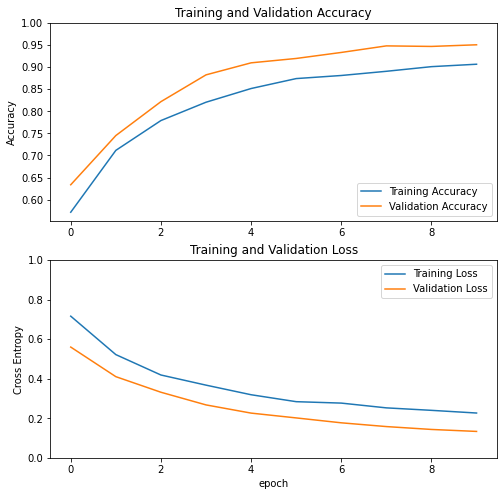

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:07 - loss: 0.2286 - accuracy: 0.9062

 2/63 [..............................] - ETA: 15s - loss: 0.2021 - accuracy: 0.9219 

 3/63 [>.............................] - ETA: 15s - loss: 0.2189 - accuracy: 0.9132

 4/63 [>.............................] - ETA: 14s - loss: 0.2215 - accuracy: 0.9095

 5/63 [=>............................] - ETA: 14s - loss: 0.2265 - accuracy: 0.9076

 6/63 [=>............................] - ETA: 14s - loss: 0.2289 - accuracy: 0.9065

 7/63 [==>...........................] - ETA: 13s - loss: 0.2301 - accuracy: 0.9058

 8/63 [==>...........................] - ETA: 13s - loss: 0.2296 - accuracy: 0.9049

 9/63 [===>..........................] - ETA: 13s - loss: 0.2285 - accuracy: 0.9047

10/63 [===>..........................] - ETA: 13s - loss: 0.2271 - accuracy: 0.9051

11/63 [====>.........................] - ETA: 12s - loss: 0.2257 - accuracy: 0.9052

12/63 [====>.........................] - ETA: 12s - loss: 0.2245 - accuracy: 0.9053

13/63 [=====>........................] - ETA: 12s - loss: 0.2234 - accuracy: 0.9058

14/63 [=====>........................] - ETA: 12s - loss: 0.2215 - accuracy: 0.9066

15/63 [======>.......................] - ETA: 12s - loss: 0.2195 - accuracy: 0.9075

16/63 [======>.......................] - ETA: 11s - loss: 0.2175 - accuracy: 0.9084

17/63 [=======>......................] - ETA: 11s - loss: 0.2156 - accuracy: 0.9093

18/63 [=======>......................] - ETA: 11s - loss: 0.2143 - accuracy: 0.9099

19/63 [========>.....................] - ETA: 11s - loss: 0.2132 - accuracy: 0.9104

20/63 [========>.....................] - ETA: 10s - loss: 0.2120 - accuracy: 0.9110

21/63 [=========>....................] - ETA: 10s - loss: 0.2109 - accuracy: 0.9115

22/63 [=========>....................] - ETA: 10s - loss: 0.2099 - accuracy: 0.9119

23/63 [=========>....................] - ETA: 10s - loss: 0.2088 - accuracy: 0.9123

24/63 [==========>...................] - ETA: 9s - loss: 0.2076 - accuracy: 0.9127 

25/63 [==========>...................] - ETA: 9s - loss: 0.2065 - accuracy: 0.9130

26/63 [===========>..................] - ETA: 9s - loss: 0.2053 - accuracy: 0.9134

27/63 [===========>..................] - ETA: 9s - loss: 0.2040 - accuracy: 0.9138

28/63 [============>.................] - ETA: 8s - loss: 0.2028 - accuracy: 0.9141

29/63 [============>.................] - ETA: 8s - loss: 0.2018 - accuracy: 0.9145

30/63 [=============>................] - ETA: 8s - loss: 0.2008 - accuracy: 0.9148

31/63 [=============>................] - ETA: 8s - loss: 0.1999 - accuracy: 0.9150

32/63 [==============>...............] - ETA: 7s - loss: 0.1991 - accuracy: 0.9152

33/63 [==============>...............] - ETA: 7s - loss: 0.1982 - accuracy: 0.9154

34/63 [===============>..............] - ETA: 7s - loss: 0.1973 - accuracy: 0.9157

35/63 [===============>..............] - ETA: 7s - loss: 0.1964 - accuracy: 0.9160

36/63 [================>.............] - ETA: 6s - loss: 0.1955 - accuracy: 0.9163

37/63 [================>.............] - ETA: 6s - loss: 0.1945 - accuracy: 0.9166

38/63 [=================>............] - ETA: 6s - loss: 0.1937 - accuracy: 0.9168

39/63 [=================>............] - ETA: 6s - loss: 0.1929 - accuracy: 0.9171

40/63 [==================>...........] - ETA: 5s - loss: 0.1922 - accuracy: 0.9173

41/63 [==================>...........] - ETA: 5s - loss: 0.1914 - accuracy: 0.9176

42/63 [===================>..........] - ETA: 5s - loss: 0.1906 - accuracy: 0.9178

43/63 [===================>..........] - ETA: 5s - loss: 0.1899 - accuracy: 0.9180

44/63 [===================>..........] - ETA: 4s - loss: 0.1893 - accuracy: 0.9183

45/63 [====================>.........] - ETA: 4s - loss: 0.1887 - accuracy: 0.9184

46/63 [====================>.........] - ETA: 4s - loss: 0.1882 - accuracy: 0.9186

47/63 [=====================>........] - ETA: 4s - loss: 0.1878 - accuracy: 0.9187

48/63 [=====================>........] - ETA: 3s - loss: 0.1873 - accuracy: 0.9188

49/63 [======================>.......] - ETA: 3s - loss: 0.1869 - accuracy: 0.9189

50/63 [======================>.......] - ETA: 3s - loss: 0.1866 - accuracy: 0.9190

51/63 [=======================>......] - ETA: 3s - loss: 0.1863 - accuracy: 0.9191

52/63 [=======================>......] - ETA: 2s - loss: 0.1860 - accuracy: 0.9191

53/63 [========================>.....] - ETA: 2s - loss: 0.1857 - accuracy: 0.9192

54/63 [========================>.....] - ETA: 2s - loss: 0.1853 - accuracy: 0.9193

55/63 [=========================>....] - ETA: 2s - loss: 0.1850 - accuracy: 0.9193

56/63 [=========================>....] - ETA: 1s - loss: 0.1846 - accuracy: 0.9194

57/63 [==========================>...] - ETA: 1s - loss: 0.1843 - accuracy: 0.9195

58/63 [==========================>...] - ETA: 1s - loss: 0.1839 - accuracy: 0.9196

59/63 [===========================>..] - ETA: 1s - loss: 0.1836 - accuracy: 0.9196

60/63 [===========================>..] - ETA: 0s - loss: 0.1833 - accuracy: 0.9197

61/63 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9198

62/63 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9199

63/63 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9200

63/63 [==============================] - 24s 328ms/step - loss: 0.1819 - accuracy: 0.9201 - val_loss: 0.0569 - val_accuracy: 0.9814


Epoch 11/20


 1/63 [..............................] - ETA: 32s - loss: 0.1096 - accuracy: 0.9688

 2/63 [..............................] - ETA: 16s - loss: 0.1277 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 15s - loss: 0.1300 - accuracy: 0.9653

 4/63 [>.............................] - ETA: 15s - loss: 0.1248 - accuracy: 0.9661

 5/63 [=>............................] - ETA: 15s - loss: 0.1210 - accuracy: 0.9654

 6/63 [=>............................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9651

 7/63 [==>...........................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9650

 8/63 [==>...........................] - ETA: 14s - loss: 0.1217 - accuracy: 0.9645

 9/63 [===>..........................] - ETA: 14s - loss: 0.1236 - accuracy: 0.9634

10/63 [===>..........................] - ETA: 13s - loss: 0.1256 - accuracy: 0.9621

11/63 [====>.........................] - ETA: 13s - loss: 0.1267 - accuracy: 0.9611

12/63 [====>.........................] - ETA: 13s - loss: 0.1274 - accuracy: 0.9605

13/63 [=====>........................] - ETA: 12s - loss: 0.1279 - accuracy: 0.9596

14/63 [=====>........................] - ETA: 12s - loss: 0.1278 - accuracy: 0.9592

15/63 [======>.......................] - ETA: 12s - loss: 0.1276 - accuracy: 0.9588

16/63 [======>.......................] - ETA: 12s - loss: 0.1272 - accuracy: 0.9586

17/63 [=======>......................] - ETA: 11s - loss: 0.1266 - accuracy: 0.9584

18/63 [=======>......................] - ETA: 11s - loss: 0.1263 - accuracy: 0.9581

19/63 [========>.....................] - ETA: 11s - loss: 0.1259 - accuracy: 0.9577

20/63 [========>.....................] - ETA: 11s - loss: 0.1257 - accuracy: 0.9574

21/63 [=========>....................] - ETA: 10s - loss: 0.1253 - accuracy: 0.9571

22/63 [=========>....................] - ETA: 10s - loss: 0.1250 - accuracy: 0.9569

23/63 [=========>....................] - ETA: 10s - loss: 0.1248 - accuracy: 0.9566

24/63 [==========>...................] - ETA: 9s - loss: 0.1246 - accuracy: 0.9564 

25/63 [==========>...................] - ETA: 9s - loss: 0.1242 - accuracy: 0.9563

26/63 [===========>..................] - ETA: 9s - loss: 0.1239 - accuracy: 0.9562

27/63 [===========>..................] - ETA: 9s - loss: 0.1235 - accuracy: 0.9562

28/63 [============>.................] - ETA: 8s - loss: 0.1232 - accuracy: 0.9561

29/63 [============>.................] - ETA: 8s - loss: 0.1230 - accuracy: 0.9559

30/63 [=============>................] - ETA: 8s - loss: 0.1229 - accuracy: 0.9557

31/63 [=============>................] - ETA: 8s - loss: 0.1232 - accuracy: 0.9554

32/63 [==============>...............] - ETA: 7s - loss: 0.1233 - accuracy: 0.9551

33/63 [==============>...............] - ETA: 7s - loss: 0.1236 - accuracy: 0.9548

34/63 [===============>..............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9546

35/63 [===============>..............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9544

36/63 [================>.............] - ETA: 6s - loss: 0.1237 - accuracy: 0.9543

37/63 [================>.............] - ETA: 6s - loss: 0.1237 - accuracy: 0.9542

38/63 [=================>............] - ETA: 6s - loss: 0.1236 - accuracy: 0.9541

39/63 [=================>............] - ETA: 6s - loss: 0.1234 - accuracy: 0.9540

40/63 [==================>...........] - ETA: 5s - loss: 0.1233 - accuracy: 0.9540

41/63 [==================>...........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9540

42/63 [===================>..........] - ETA: 5s - loss: 0.1231 - accuracy: 0.9539

43/63 [===================>..........] - ETA: 5s - loss: 0.1229 - accuracy: 0.9539

44/63 [===================>..........] - ETA: 4s - loss: 0.1227 - accuracy: 0.9539

45/63 [====================>.........] - ETA: 4s - loss: 0.1225 - accuracy: 0.9539

46/63 [====================>.........] - ETA: 4s - loss: 0.1223 - accuracy: 0.9540

47/63 [=====================>........] - ETA: 4s - loss: 0.1221 - accuracy: 0.9540

48/63 [=====================>........] - ETA: 3s - loss: 0.1220 - accuracy: 0.9540

49/63 [======================>.......] - ETA: 3s - loss: 0.1218 - accuracy: 0.9540

50/63 [======================>.......] - ETA: 3s - loss: 0.1216 - accuracy: 0.9541

51/63 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9541

52/63 [=======================>......] - ETA: 2s - loss: 0.1213 - accuracy: 0.9541

53/63 [========================>.....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9540

54/63 [========================>.....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9540

55/63 [=========================>....] - ETA: 2s - loss: 0.1211 - accuracy: 0.9540

56/63 [=========================>....] - ETA: 1s - loss: 0.1211 - accuracy: 0.9539

57/63 [==========================>...] - ETA: 1s - loss: 0.1210 - accuracy: 0.9539

58/63 [==========================>...] - ETA: 1s - loss: 0.1210 - accuracy: 0.9538

59/63 [===========================>..] - ETA: 1s - loss: 0.1210 - accuracy: 0.9538

60/63 [===========================>..] - ETA: 0s - loss: 0.1209 - accuracy: 0.9538

61/63 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9537

62/63 [============================>.] - ETA: 0s - loss: 0.1208 - accuracy: 0.9537

63/63 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9536

63/63 [==============================] - 21s 325ms/step - loss: 0.1207 - accuracy: 0.9536 - val_loss: 0.0501 - val_accuracy: 0.9851


Epoch 12/20


 1/63 [..............................] - ETA: 33s - loss: 0.0886 - accuracy: 0.9375

 2/63 [..............................] - ETA: 16s - loss: 0.1075 - accuracy: 0.9297

 3/63 [>.............................] - ETA: 15s - loss: 0.1052 - accuracy: 0.9323

 4/63 [>.............................] - ETA: 15s - loss: 0.1048 - accuracy: 0.9355

 5/63 [=>............................] - ETA: 15s - loss: 0.1015 - accuracy: 0.9397

 6/63 [=>............................] - ETA: 15s - loss: 0.0989 - accuracy: 0.9428

 7/63 [==>...........................] - ETA: 15s - loss: 0.0964 - accuracy: 0.9452

 8/63 [==>...........................] - ETA: 14s - loss: 0.0960 - accuracy: 0.9467

 9/63 [===>..........................] - ETA: 14s - loss: 0.0954 - accuracy: 0.9480

10/63 [===>..........................] - ETA: 14s - loss: 0.0959 - accuracy: 0.9488

11/63 [====>.........................] - ETA: 13s - loss: 0.0962 - accuracy: 0.9493

12/63 [====>.........................] - ETA: 13s - loss: 0.0960 - accuracy: 0.9501

13/63 [=====>........................] - ETA: 13s - loss: 0.0958 - accuracy: 0.9508

14/63 [=====>........................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9510

15/63 [======>.......................] - ETA: 12s - loss: 0.0975 - accuracy: 0.9510

16/63 [======>.......................] - ETA: 12s - loss: 0.0984 - accuracy: 0.9510

17/63 [=======>......................] - ETA: 12s - loss: 0.0992 - accuracy: 0.9509

18/63 [=======>......................] - ETA: 11s - loss: 0.1002 - accuracy: 0.9506

19/63 [========>.....................] - ETA: 11s - loss: 0.1009 - accuracy: 0.9505

20/63 [========>.....................] - ETA: 11s - loss: 0.1015 - accuracy: 0.9505

21/63 [=========>....................] - ETA: 11s - loss: 0.1019 - accuracy: 0.9505

22/63 [=========>....................] - ETA: 10s - loss: 0.1023 - accuracy: 0.9505

23/63 [=========>....................] - ETA: 10s - loss: 0.1026 - accuracy: 0.9505

24/63 [==========>...................] - ETA: 10s - loss: 0.1027 - accuracy: 0.9507

25/63 [==========>...................] - ETA: 9s - loss: 0.1026 - accuracy: 0.9509 

26/63 [===========>..................] - ETA: 9s - loss: 0.1028 - accuracy: 0.9511

27/63 [===========>..................] - ETA: 9s - loss: 0.1028 - accuracy: 0.9512

28/63 [============>.................] - ETA: 9s - loss: 0.1030 - accuracy: 0.9514

29/63 [============>.................] - ETA: 8s - loss: 0.1033 - accuracy: 0.9514

30/63 [=============>................] - ETA: 8s - loss: 0.1035 - accuracy: 0.9515

31/63 [=============>................] - ETA: 8s - loss: 0.1037 - accuracy: 0.9516

32/63 [==============>...............] - ETA: 8s - loss: 0.1039 - accuracy: 0.9517

33/63 [==============>...............] - ETA: 7s - loss: 0.1040 - accuracy: 0.9517

34/63 [===============>..............] - ETA: 7s - loss: 0.1041 - accuracy: 0.9518

35/63 [===============>..............] - ETA: 7s - loss: 0.1042 - accuracy: 0.9518

36/63 [================>.............] - ETA: 6s - loss: 0.1042 - accuracy: 0.9519

37/63 [================>.............] - ETA: 6s - loss: 0.1043 - accuracy: 0.9519

38/63 [=================>............] - ETA: 6s - loss: 0.1044 - accuracy: 0.9520

39/63 [=================>............] - ETA: 6s - loss: 0.1046 - accuracy: 0.9520

40/63 [==================>...........] - ETA: 5s - loss: 0.1047 - accuracy: 0.9520

41/63 [==================>...........] - ETA: 5s - loss: 0.1048 - accuracy: 0.9521

42/63 [===================>..........] - ETA: 5s - loss: 0.1049 - accuracy: 0.9521

43/63 [===================>..........] - ETA: 5s - loss: 0.1050 - accuracy: 0.9522

44/63 [===================>..........] - ETA: 4s - loss: 0.1051 - accuracy: 0.9522

45/63 [====================>.........] - ETA: 4s - loss: 0.1052 - accuracy: 0.9522

46/63 [====================>.........] - ETA: 4s - loss: 0.1054 - accuracy: 0.9522

47/63 [=====================>........] - ETA: 4s - loss: 0.1056 - accuracy: 0.9521

48/63 [=====================>........] - ETA: 3s - loss: 0.1059 - accuracy: 0.9520

49/63 [======================>.......] - ETA: 3s - loss: 0.1061 - accuracy: 0.9519

50/63 [======================>.......] - ETA: 3s - loss: 0.1063 - accuracy: 0.9519

51/63 [=======================>......] - ETA: 3s - loss: 0.1065 - accuracy: 0.9518

52/63 [=======================>......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9517

53/63 [========================>.....] - ETA: 2s - loss: 0.1069 - accuracy: 0.9516

54/63 [========================>.....] - ETA: 2s - loss: 0.1070 - accuracy: 0.9516

55/63 [=========================>....] - ETA: 2s - loss: 0.1072 - accuracy: 0.9515

56/63 [=========================>....] - ETA: 1s - loss: 0.1073 - accuracy: 0.9515

57/63 [==========================>...] - ETA: 1s - loss: 0.1074 - accuracy: 0.9515

58/63 [==========================>...] - ETA: 1s - loss: 0.1074 - accuracy: 0.9515

59/63 [===========================>..] - ETA: 1s - loss: 0.1075 - accuracy: 0.9514

60/63 [===========================>..] - ETA: 0s - loss: 0.1076 - accuracy: 0.9514

61/63 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9514

62/63 [============================>.] - ETA: 0s - loss: 0.1077 - accuracy: 0.9514

63/63 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9514

63/63 [==============================] - 20s 317ms/step - loss: 0.1077 - accuracy: 0.9514 - val_loss: 0.0464 - val_accuracy: 0.9827


Epoch 13/20


 1/63 [..............................] - ETA: 31s - loss: 0.1609 - accuracy: 0.9062

 2/63 [..............................] - ETA: 14s - loss: 0.1424 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 14s - loss: 0.1297 - accuracy: 0.9306

 4/63 [>.............................] - ETA: 14s - loss: 0.1190 - accuracy: 0.9382

 5/63 [=>............................] - ETA: 14s - loss: 0.1120 - accuracy: 0.9443

 6/63 [=>............................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9484

 7/63 [==>...........................] - ETA: 14s - loss: 0.1019 - accuracy: 0.9519

 8/63 [==>...........................] - ETA: 13s - loss: 0.0984 - accuracy: 0.9545

 9/63 [===>..........................] - ETA: 13s - loss: 0.0951 - accuracy: 0.9565

10/63 [===>..........................] - ETA: 13s - loss: 0.0929 - accuracy: 0.9580

11/63 [====>.........................] - ETA: 12s - loss: 0.0917 - accuracy: 0.9592

12/63 [====>.........................] - ETA: 12s - loss: 0.0903 - accuracy: 0.9605

13/63 [=====>........................] - ETA: 12s - loss: 0.0889 - accuracy: 0.9617

14/63 [=====>........................] - ETA: 12s - loss: 0.0875 - accuracy: 0.9628

15/63 [======>.......................] - ETA: 11s - loss: 0.0863 - accuracy: 0.9638

16/63 [======>.......................] - ETA: 11s - loss: 0.0852 - accuracy: 0.9646

17/63 [=======>......................] - ETA: 11s - loss: 0.0843 - accuracy: 0.9652

18/63 [=======>......................] - ETA: 11s - loss: 0.0835 - accuracy: 0.9658

19/63 [========>.....................] - ETA: 10s - loss: 0.0827 - accuracy: 0.9664

20/63 [========>.....................] - ETA: 10s - loss: 0.0828 - accuracy: 0.9667

21/63 [=========>....................] - ETA: 10s - loss: 0.0829 - accuracy: 0.9670

22/63 [=========>....................] - ETA: 10s - loss: 0.0828 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 9s - loss: 0.0829 - accuracy: 0.9675 

24/63 [==========>...................] - ETA: 9s - loss: 0.0832 - accuracy: 0.9677

25/63 [==========>...................] - ETA: 9s - loss: 0.0834 - accuracy: 0.9679

26/63 [===========>..................] - ETA: 9s - loss: 0.0835 - accuracy: 0.9681

27/63 [===========>..................] - ETA: 8s - loss: 0.0836 - accuracy: 0.9682

28/63 [============>.................] - ETA: 8s - loss: 0.0836 - accuracy: 0.9684

29/63 [============>.................] - ETA: 8s - loss: 0.0836 - accuracy: 0.9685

30/63 [=============>................] - ETA: 8s - loss: 0.0836 - accuracy: 0.9686

31/63 [=============>................] - ETA: 7s - loss: 0.0835 - accuracy: 0.9687

32/63 [==============>...............] - ETA: 7s - loss: 0.0836 - accuracy: 0.9687

33/63 [==============>...............] - ETA: 7s - loss: 0.0836 - accuracy: 0.9688

34/63 [===============>..............] - ETA: 7s - loss: 0.0837 - accuracy: 0.9688

35/63 [===============>..............] - ETA: 6s - loss: 0.0839 - accuracy: 0.9688

36/63 [================>.............] - ETA: 6s - loss: 0.0840 - accuracy: 0.9688

37/63 [================>.............] - ETA: 6s - loss: 0.0842 - accuracy: 0.9687

38/63 [=================>............] - ETA: 6s - loss: 0.0845 - accuracy: 0.9687

39/63 [=================>............] - ETA: 5s - loss: 0.0847 - accuracy: 0.9686

40/63 [==================>...........] - ETA: 5s - loss: 0.0850 - accuracy: 0.9685

41/63 [==================>...........] - ETA: 5s - loss: 0.0852 - accuracy: 0.9685

42/63 [===================>..........] - ETA: 5s - loss: 0.0854 - accuracy: 0.9684

43/63 [===================>..........] - ETA: 4s - loss: 0.0856 - accuracy: 0.9684

44/63 [===================>..........] - ETA: 4s - loss: 0.0859 - accuracy: 0.9683

45/63 [====================>.........] - ETA: 4s - loss: 0.0861 - accuracy: 0.9682

46/63 [====================>.........] - ETA: 4s - loss: 0.0864 - accuracy: 0.9681

47/63 [=====================>........] - ETA: 3s - loss: 0.0866 - accuracy: 0.9681

48/63 [=====================>........] - ETA: 3s - loss: 0.0868 - accuracy: 0.9680

49/63 [======================>.......] - ETA: 3s - loss: 0.0870 - accuracy: 0.9679

50/63 [======================>.......] - ETA: 3s - loss: 0.0872 - accuracy: 0.9679

51/63 [=======================>......] - ETA: 2s - loss: 0.0873 - accuracy: 0.9678

52/63 [=======================>......] - ETA: 2s - loss: 0.0874 - accuracy: 0.9678

53/63 [========================>.....] - ETA: 2s - loss: 0.0875 - accuracy: 0.9678

54/63 [========================>.....] - ETA: 2s - loss: 0.0877 - accuracy: 0.9678

55/63 [=========================>....] - ETA: 1s - loss: 0.0878 - accuracy: 0.9677

56/63 [=========================>....] - ETA: 1s - loss: 0.0880 - accuracy: 0.9677

57/63 [==========================>...] - ETA: 1s - loss: 0.0881 - accuracy: 0.9676

58/63 [==========================>...] - ETA: 1s - loss: 0.0883 - accuracy: 0.9676

59/63 [===========================>..] - ETA: 0s - loss: 0.0884 - accuracy: 0.9675

60/63 [===========================>..] - ETA: 0s - loss: 0.0885 - accuracy: 0.9675

61/63 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9674

62/63 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9673

63/63 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9673

63/63 [==============================] - 20s 309ms/step - loss: 0.0890 - accuracy: 0.9672 - val_loss: 0.0388 - val_accuracy: 0.9913


Epoch 14/20


 1/63 [..............................] - ETA: 31s - loss: 0.0668 - accuracy: 0.9688

 2/63 [..............................] - ETA: 15s - loss: 0.0524 - accuracy: 0.9766

 3/63 [>.............................] - ETA: 15s - loss: 0.0486 - accuracy: 0.9809

 4/63 [>.............................] - ETA: 15s - loss: 0.0523 - accuracy: 0.9818

 5/63 [=>............................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9779

 6/63 [=>............................] - ETA: 14s - loss: 0.0666 - accuracy: 0.9755

 7/63 [==>...........................] - ETA: 13s - loss: 0.0691 - accuracy: 0.9746

 8/63 [==>...........................] - ETA: 13s - loss: 0.0731 - accuracy: 0.9733

 9/63 [===>..........................] - ETA: 13s - loss: 0.0753 - accuracy: 0.9728

10/63 [===>..........................] - ETA: 13s - loss: 0.0778 - accuracy: 0.9718

11/63 [====>.........................] - ETA: 12s - loss: 0.0795 - accuracy: 0.9710

12/63 [====>.........................] - ETA: 12s - loss: 0.0815 - accuracy: 0.9699

13/63 [=====>........................] - ETA: 12s - loss: 0.0833 - accuracy: 0.9689

14/63 [=====>........................] - ETA: 11s - loss: 0.0844 - accuracy: 0.9683

15/63 [======>.......................] - ETA: 11s - loss: 0.0856 - accuracy: 0.9678

16/63 [======>.......................] - ETA: 11s - loss: 0.0865 - accuracy: 0.9673

17/63 [=======>......................] - ETA: 11s - loss: 0.0876 - accuracy: 0.9669

18/63 [=======>......................] - ETA: 10s - loss: 0.0885 - accuracy: 0.9665

19/63 [========>.....................] - ETA: 10s - loss: 0.0892 - accuracy: 0.9663

20/63 [========>.....................] - ETA: 10s - loss: 0.0897 - accuracy: 0.9661

21/63 [=========>....................] - ETA: 10s - loss: 0.0903 - accuracy: 0.9658

22/63 [=========>....................] - ETA: 10s - loss: 0.0906 - accuracy: 0.9656

23/63 [=========>....................] - ETA: 9s - loss: 0.0908 - accuracy: 0.9654 

24/63 [==========>...................] - ETA: 9s - loss: 0.0909 - accuracy: 0.9654

25/63 [==========>...................] - ETA: 9s - loss: 0.0910 - accuracy: 0.9653

26/63 [===========>..................] - ETA: 9s - loss: 0.0910 - accuracy: 0.9654

27/63 [===========>..................] - ETA: 8s - loss: 0.0910 - accuracy: 0.9654

28/63 [============>.................] - ETA: 8s - loss: 0.0909 - accuracy: 0.9655

29/63 [============>.................] - ETA: 8s - loss: 0.0908 - accuracy: 0.9656

30/63 [=============>................] - ETA: 8s - loss: 0.0906 - accuracy: 0.9657

31/63 [=============>................] - ETA: 7s - loss: 0.0904 - accuracy: 0.9658

32/63 [==============>...............] - ETA: 7s - loss: 0.0904 - accuracy: 0.9658

33/63 [==============>...............] - ETA: 7s - loss: 0.0904 - accuracy: 0.9659

34/63 [===============>..............] - ETA: 7s - loss: 0.0904 - accuracy: 0.9658

35/63 [===============>..............] - ETA: 6s - loss: 0.0904 - accuracy: 0.9658

36/63 [================>.............] - ETA: 6s - loss: 0.0904 - accuracy: 0.9658

37/63 [================>.............] - ETA: 6s - loss: 0.0904 - accuracy: 0.9658

38/63 [=================>............] - ETA: 6s - loss: 0.0903 - accuracy: 0.9658

39/63 [=================>............] - ETA: 5s - loss: 0.0904 - accuracy: 0.9658

40/63 [==================>...........] - ETA: 5s - loss: 0.0905 - accuracy: 0.9657

41/63 [==================>...........] - ETA: 5s - loss: 0.0906 - accuracy: 0.9657

42/63 [===================>..........] - ETA: 5s - loss: 0.0908 - accuracy: 0.9656

43/63 [===================>..........] - ETA: 4s - loss: 0.0909 - accuracy: 0.9655

44/63 [===================>..........] - ETA: 4s - loss: 0.0911 - accuracy: 0.9654

45/63 [====================>.........] - ETA: 4s - loss: 0.0912 - accuracy: 0.9654

46/63 [====================>.........] - ETA: 4s - loss: 0.0913 - accuracy: 0.9653

47/63 [=====================>........] - ETA: 3s - loss: 0.0914 - accuracy: 0.9653

48/63 [=====================>........] - ETA: 3s - loss: 0.0914 - accuracy: 0.9653

49/63 [======================>.......] - ETA: 3s - loss: 0.0915 - accuracy: 0.9652

50/63 [======================>.......] - ETA: 3s - loss: 0.0915 - accuracy: 0.9652

51/63 [=======================>......] - ETA: 2s - loss: 0.0915 - accuracy: 0.9651

52/63 [=======================>......] - ETA: 2s - loss: 0.0915 - accuracy: 0.9651

53/63 [========================>.....] - ETA: 2s - loss: 0.0915 - accuracy: 0.9651

54/63 [========================>.....] - ETA: 2s - loss: 0.0915 - accuracy: 0.9650

55/63 [=========================>....] - ETA: 1s - loss: 0.0915 - accuracy: 0.9650

56/63 [=========================>....] - ETA: 1s - loss: 0.0915 - accuracy: 0.9650

57/63 [==========================>...] - ETA: 1s - loss: 0.0915 - accuracy: 0.9650

58/63 [==========================>...] - ETA: 1s - loss: 0.0915 - accuracy: 0.9649

59/63 [===========================>..] - ETA: 0s - loss: 0.0915 - accuracy: 0.9649

60/63 [===========================>..] - ETA: 0s - loss: 0.0915 - accuracy: 0.9649

61/63 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9649

62/63 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9648

63/63 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9648

63/63 [==============================] - 20s 312ms/step - loss: 0.0916 - accuracy: 0.9648 - val_loss: 0.0441 - val_accuracy: 0.9864


Epoch 15/20


 1/63 [..............................] - ETA: 32s - loss: 0.0182 - accuracy: 1.0000

 2/63 [..............................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 15s - loss: 0.0439 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9785

 5/63 [=>............................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9791

 6/63 [=>............................] - ETA: 14s - loss: 0.0483 - accuracy: 0.9791

 7/63 [==>...........................] - ETA: 14s - loss: 0.0492 - accuracy: 0.9789

 8/63 [==>...........................] - ETA: 13s - loss: 0.0502 - accuracy: 0.9786

 9/63 [===>..........................] - ETA: 13s - loss: 0.0530 - accuracy: 0.9779

10/63 [===>..........................] - ETA: 13s - loss: 0.0551 - accuracy: 0.9773

11/63 [====>.........................] - ETA: 13s - loss: 0.0564 - accuracy: 0.9770

12/63 [====>.........................] - ETA: 12s - loss: 0.0574 - accuracy: 0.9766

13/63 [=====>........................] - ETA: 12s - loss: 0.0587 - accuracy: 0.9758

14/63 [=====>........................] - ETA: 12s - loss: 0.0599 - accuracy: 0.9753

15/63 [======>.......................] - ETA: 12s - loss: 0.0606 - accuracy: 0.9750

16/63 [======>.......................] - ETA: 11s - loss: 0.0610 - accuracy: 0.9748

17/63 [=======>......................] - ETA: 11s - loss: 0.0615 - accuracy: 0.9747

18/63 [=======>......................] - ETA: 11s - loss: 0.0622 - accuracy: 0.9745

19/63 [========>.....................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9739

20/63 [========>.....................] - ETA: 10s - loss: 0.0646 - accuracy: 0.9734

21/63 [=========>....................] - ETA: 10s - loss: 0.0654 - accuracy: 0.9730

22/63 [=========>....................] - ETA: 10s - loss: 0.0661 - accuracy: 0.9727

23/63 [=========>....................] - ETA: 10s - loss: 0.0666 - accuracy: 0.9724

24/63 [==========>...................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9722 

25/63 [==========>...................] - ETA: 9s - loss: 0.0675 - accuracy: 0.9720

26/63 [===========>..................] - ETA: 9s - loss: 0.0679 - accuracy: 0.9718

27/63 [===========>..................] - ETA: 9s - loss: 0.0684 - accuracy: 0.9716

28/63 [============>.................] - ETA: 8s - loss: 0.0688 - accuracy: 0.9713

29/63 [============>.................] - ETA: 8s - loss: 0.0692 - accuracy: 0.9712

30/63 [=============>................] - ETA: 8s - loss: 0.0695 - accuracy: 0.9710

31/63 [=============>................] - ETA: 8s - loss: 0.0698 - accuracy: 0.9709

32/63 [==============>...............] - ETA: 7s - loss: 0.0700 - accuracy: 0.9708

33/63 [==============>...............] - ETA: 7s - loss: 0.0702 - accuracy: 0.9707

34/63 [===============>..............] - ETA: 7s - loss: 0.0704 - accuracy: 0.9706

35/63 [===============>..............] - ETA: 6s - loss: 0.0706 - accuracy: 0.9704

36/63 [================>.............] - ETA: 6s - loss: 0.0709 - accuracy: 0.9703

37/63 [================>.............] - ETA: 6s - loss: 0.0711 - accuracy: 0.9702

38/63 [=================>............] - ETA: 6s - loss: 0.0712 - accuracy: 0.9701

39/63 [=================>............] - ETA: 5s - loss: 0.0714 - accuracy: 0.9700

40/63 [==================>...........] - ETA: 5s - loss: 0.0715 - accuracy: 0.9699

41/63 [==================>...........] - ETA: 5s - loss: 0.0717 - accuracy: 0.9698

42/63 [===================>..........] - ETA: 5s - loss: 0.0717 - accuracy: 0.9698

43/63 [===================>..........] - ETA: 4s - loss: 0.0718 - accuracy: 0.9697

44/63 [===================>..........] - ETA: 4s - loss: 0.0719 - accuracy: 0.9696

45/63 [====================>.........] - ETA: 4s - loss: 0.0719 - accuracy: 0.9696

46/63 [====================>.........] - ETA: 4s - loss: 0.0720 - accuracy: 0.9695

47/63 [=====================>........] - ETA: 3s - loss: 0.0721 - accuracy: 0.9694

48/63 [=====================>........] - ETA: 3s - loss: 0.0723 - accuracy: 0.9693

49/63 [======================>.......] - ETA: 3s - loss: 0.0724 - accuracy: 0.9692

50/63 [======================>.......] - ETA: 3s - loss: 0.0725 - accuracy: 0.9691

51/63 [=======================>......] - ETA: 2s - loss: 0.0726 - accuracy: 0.9690

52/63 [=======================>......] - ETA: 2s - loss: 0.0727 - accuracy: 0.9689

53/63 [========================>.....] - ETA: 2s - loss: 0.0728 - accuracy: 0.9688

54/63 [========================>.....] - ETA: 2s - loss: 0.0728 - accuracy: 0.9688

55/63 [=========================>....] - ETA: 1s - loss: 0.0729 - accuracy: 0.9687

56/63 [=========================>....] - ETA: 1s - loss: 0.0730 - accuracy: 0.9686

57/63 [==========================>...] - ETA: 1s - loss: 0.0731 - accuracy: 0.9685

58/63 [==========================>...] - ETA: 1s - loss: 0.0733 - accuracy: 0.9683

59/63 [===========================>..] - ETA: 0s - loss: 0.0734 - accuracy: 0.9682

60/63 [===========================>..] - ETA: 0s - loss: 0.0736 - accuracy: 0.9681

61/63 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9680

62/63 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9678

63/63 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9677

63/63 [==============================] - 20s 312ms/step - loss: 0.0741 - accuracy: 0.9676 - val_loss: 0.0305 - val_accuracy: 0.9889


Epoch 16/20


 1/63 [..............................] - ETA: 31s - loss: 0.1475 - accuracy: 0.9375

 2/63 [..............................] - ETA: 15s - loss: 0.1181 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 15s - loss: 0.1005 - accuracy: 0.9618

 4/63 [>.............................] - ETA: 14s - loss: 0.0906 - accuracy: 0.9674

 5/63 [=>............................] - ETA: 14s - loss: 0.0949 - accuracy: 0.9690

 6/63 [=>............................] - ETA: 14s - loss: 0.0997 - accuracy: 0.9689

 7/63 [==>...........................] - ETA: 13s - loss: 0.1019 - accuracy: 0.9689

 8/63 [==>...........................] - ETA: 13s - loss: 0.1022 - accuracy: 0.9689

 9/63 [===>..........................] - ETA: 13s - loss: 0.1022 - accuracy: 0.9689

10/63 [===>..........................] - ETA: 13s - loss: 0.1015 - accuracy: 0.9692

11/63 [====>.........................] - ETA: 12s - loss: 0.1007 - accuracy: 0.9694

12/63 [====>.........................] - ETA: 12s - loss: 0.0999 - accuracy: 0.9696

13/63 [=====>........................] - ETA: 12s - loss: 0.0992 - accuracy: 0.9697

14/63 [=====>........................] - ETA: 12s - loss: 0.0984 - accuracy: 0.9699

15/63 [======>.......................] - ETA: 11s - loss: 0.0974 - accuracy: 0.9703

16/63 [======>.......................] - ETA: 11s - loss: 0.0963 - accuracy: 0.9705

17/63 [=======>......................] - ETA: 11s - loss: 0.0952 - accuracy: 0.9708

18/63 [=======>......................] - ETA: 11s - loss: 0.0942 - accuracy: 0.9709

19/63 [========>.....................] - ETA: 10s - loss: 0.0931 - accuracy: 0.9712

20/63 [========>.....................] - ETA: 10s - loss: 0.0923 - accuracy: 0.9713

21/63 [=========>....................] - ETA: 10s - loss: 0.0916 - accuracy: 0.9713

22/63 [=========>....................] - ETA: 10s - loss: 0.0910 - accuracy: 0.9713

23/63 [=========>....................] - ETA: 9s - loss: 0.0904 - accuracy: 0.9713 

24/63 [==========>...................] - ETA: 9s - loss: 0.0901 - accuracy: 0.9712

25/63 [==========>...................] - ETA: 9s - loss: 0.0898 - accuracy: 0.9711

26/63 [===========>..................] - ETA: 9s - loss: 0.0894 - accuracy: 0.9710

27/63 [===========>..................] - ETA: 8s - loss: 0.0890 - accuracy: 0.9710

28/63 [============>.................] - ETA: 8s - loss: 0.0886 - accuracy: 0.9710

29/63 [============>.................] - ETA: 8s - loss: 0.0882 - accuracy: 0.9709

30/63 [=============>................] - ETA: 8s - loss: 0.0880 - accuracy: 0.9708

31/63 [=============>................] - ETA: 7s - loss: 0.0877 - accuracy: 0.9708

32/63 [==============>...............] - ETA: 7s - loss: 0.0875 - accuracy: 0.9707

33/63 [==============>...............] - ETA: 7s - loss: 0.0873 - accuracy: 0.9706

34/63 [===============>..............] - ETA: 7s - loss: 0.0870 - accuracy: 0.9706

35/63 [===============>..............] - ETA: 6s - loss: 0.0869 - accuracy: 0.9706

36/63 [================>.............] - ETA: 6s - loss: 0.0867 - accuracy: 0.9706

37/63 [================>.............] - ETA: 6s - loss: 0.0865 - accuracy: 0.9706

38/63 [=================>............] - ETA: 6s - loss: 0.0863 - accuracy: 0.9706

39/63 [=================>............] - ETA: 5s - loss: 0.0861 - accuracy: 0.9706

40/63 [==================>...........] - ETA: 5s - loss: 0.0860 - accuracy: 0.9706

41/63 [==================>...........] - ETA: 5s - loss: 0.0858 - accuracy: 0.9706

42/63 [===================>..........] - ETA: 5s - loss: 0.0856 - accuracy: 0.9706

43/63 [===================>..........] - ETA: 4s - loss: 0.0854 - accuracy: 0.9706

44/63 [===================>..........] - ETA: 4s - loss: 0.0852 - accuracy: 0.9706

45/63 [====================>.........] - ETA: 4s - loss: 0.0849 - accuracy: 0.9707

46/63 [====================>.........] - ETA: 4s - loss: 0.0847 - accuracy: 0.9707

47/63 [=====================>........] - ETA: 3s - loss: 0.0844 - accuracy: 0.9707

48/63 [=====================>........] - ETA: 3s - loss: 0.0843 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 3s - loss: 0.0842 - accuracy: 0.9707

50/63 [======================>.......] - ETA: 3s - loss: 0.0842 - accuracy: 0.9707

51/63 [=======================>......] - ETA: 2s - loss: 0.0842 - accuracy: 0.9707

52/63 [=======================>......] - ETA: 2s - loss: 0.0842 - accuracy: 0.9707

53/63 [========================>.....] - ETA: 2s - loss: 0.0841 - accuracy: 0.9707

54/63 [========================>.....] - ETA: 2s - loss: 0.0841 - accuracy: 0.9706

55/63 [=========================>....] - ETA: 1s - loss: 0.0841 - accuracy: 0.9706

56/63 [=========================>....] - ETA: 1s - loss: 0.0841 - accuracy: 0.9706

57/63 [==========================>...] - ETA: 1s - loss: 0.0841 - accuracy: 0.9705

58/63 [==========================>...] - ETA: 1s - loss: 0.0842 - accuracy: 0.9705

59/63 [===========================>..] - ETA: 0s - loss: 0.0842 - accuracy: 0.9705

60/63 [===========================>..] - ETA: 0s - loss: 0.0843 - accuracy: 0.9704

61/63 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9704

62/63 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9703

63/63 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9703

63/63 [==============================] - 20s 312ms/step - loss: 0.0844 - accuracy: 0.9703 - val_loss: 0.0427 - val_accuracy: 0.9889


Epoch 17/20


 1/63 [..............................] - ETA: 31s - loss: 0.1956 - accuracy: 0.9062

 2/63 [..............................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9297

 3/63 [>.............................] - ETA: 14s - loss: 0.1375 - accuracy: 0.9392

 4/63 [>.............................] - ETA: 14s - loss: 0.1267 - accuracy: 0.9447

 5/63 [=>............................] - ETA: 14s - loss: 0.1254 - accuracy: 0.9470

 6/63 [=>............................] - ETA: 13s - loss: 0.1219 - accuracy: 0.9497

 7/63 [==>...........................] - ETA: 13s - loss: 0.1198 - accuracy: 0.9505

 8/63 [==>...........................] - ETA: 13s - loss: 0.1168 - accuracy: 0.9518

 9/63 [===>..........................] - ETA: 13s - loss: 0.1140 - accuracy: 0.9533

10/63 [===>..........................] - ETA: 12s - loss: 0.1111 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 12s - loss: 0.1084 - accuracy: 0.9561

12/63 [====>.........................] - ETA: 12s - loss: 0.1060 - accuracy: 0.9572

13/63 [=====>........................] - ETA: 12s - loss: 0.1036 - accuracy: 0.9581

14/63 [=====>........................] - ETA: 11s - loss: 0.1013 - accuracy: 0.9590

15/63 [======>.......................] - ETA: 11s - loss: 0.0991 - accuracy: 0.9599

16/63 [======>.......................] - ETA: 11s - loss: 0.0971 - accuracy: 0.9607

17/63 [=======>......................] - ETA: 11s - loss: 0.0956 - accuracy: 0.9613

18/63 [=======>......................] - ETA: 11s - loss: 0.0941 - accuracy: 0.9619

19/63 [========>.....................] - ETA: 10s - loss: 0.0927 - accuracy: 0.9625

20/63 [========>.....................] - ETA: 10s - loss: 0.0913 - accuracy: 0.9631

21/63 [=========>....................] - ETA: 10s - loss: 0.0899 - accuracy: 0.9636

22/63 [=========>....................] - ETA: 10s - loss: 0.0888 - accuracy: 0.9641

23/63 [=========>....................] - ETA: 9s - loss: 0.0877 - accuracy: 0.9645 

24/63 [==========>...................] - ETA: 9s - loss: 0.0868 - accuracy: 0.9648

25/63 [==========>...................] - ETA: 9s - loss: 0.0860 - accuracy: 0.9650

26/63 [===========>..................] - ETA: 9s - loss: 0.0854 - accuracy: 0.9651

27/63 [===========>..................] - ETA: 8s - loss: 0.0847 - accuracy: 0.9653

28/63 [============>.................] - ETA: 8s - loss: 0.0842 - accuracy: 0.9654

29/63 [============>.................] - ETA: 8s - loss: 0.0837 - accuracy: 0.9655

30/63 [=============>................] - ETA: 8s - loss: 0.0833 - accuracy: 0.9656

31/63 [=============>................] - ETA: 7s - loss: 0.0830 - accuracy: 0.9657

32/63 [==============>...............] - ETA: 7s - loss: 0.0827 - accuracy: 0.9658

33/63 [==============>...............] - ETA: 7s - loss: 0.0825 - accuracy: 0.9660

34/63 [===============>..............] - ETA: 7s - loss: 0.0821 - accuracy: 0.9661

35/63 [===============>..............] - ETA: 6s - loss: 0.0819 - accuracy: 0.9662

36/63 [================>.............] - ETA: 6s - loss: 0.0816 - accuracy: 0.9663

37/63 [================>.............] - ETA: 6s - loss: 0.0814 - accuracy: 0.9664

38/63 [=================>............] - ETA: 6s - loss: 0.0812 - accuracy: 0.9664

39/63 [=================>............] - ETA: 5s - loss: 0.0810 - accuracy: 0.9665

40/63 [==================>...........] - ETA: 5s - loss: 0.0808 - accuracy: 0.9666

41/63 [==================>...........] - ETA: 5s - loss: 0.0805 - accuracy: 0.9667

42/63 [===================>..........] - ETA: 5s - loss: 0.0803 - accuracy: 0.9668

43/63 [===================>..........] - ETA: 4s - loss: 0.0800 - accuracy: 0.9669

44/63 [===================>..........] - ETA: 4s - loss: 0.0797 - accuracy: 0.9670

45/63 [====================>.........] - ETA: 4s - loss: 0.0794 - accuracy: 0.9671

46/63 [====================>.........] - ETA: 4s - loss: 0.0791 - accuracy: 0.9673

47/63 [=====================>........] - ETA: 3s - loss: 0.0788 - accuracy: 0.9674

48/63 [=====================>........] - ETA: 3s - loss: 0.0785 - accuracy: 0.9675

49/63 [======================>.......] - ETA: 3s - loss: 0.0783 - accuracy: 0.9677

50/63 [======================>.......] - ETA: 3s - loss: 0.0781 - accuracy: 0.9677

51/63 [=======================>......] - ETA: 2s - loss: 0.0780 - accuracy: 0.9678

52/63 [=======================>......] - ETA: 2s - loss: 0.0778 - accuracy: 0.9679

53/63 [========================>.....] - ETA: 2s - loss: 0.0776 - accuracy: 0.9680

54/63 [========================>.....] - ETA: 2s - loss: 0.0775 - accuracy: 0.9681

55/63 [=========================>....] - ETA: 1s - loss: 0.0774 - accuracy: 0.9682

56/63 [=========================>....] - ETA: 1s - loss: 0.0773 - accuracy: 0.9683

57/63 [==========================>...] - ETA: 1s - loss: 0.0773 - accuracy: 0.9683

58/63 [==========================>...] - ETA: 1s - loss: 0.0773 - accuracy: 0.9684

59/63 [===========================>..] - ETA: 0s - loss: 0.0772 - accuracy: 0.9684

60/63 [===========================>..] - ETA: 0s - loss: 0.0772 - accuracy: 0.9685

61/63 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9686

62/63 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9686

63/63 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9687

63/63 [==============================] - 20s 311ms/step - loss: 0.0770 - accuracy: 0.9687 - val_loss: 0.0315 - val_accuracy: 0.9876


Epoch 18/20


 1/63 [..............................] - ETA: 31s - loss: 0.1059 - accuracy: 0.9688

 2/63 [..............................] - ETA: 15s - loss: 0.1068 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 14s - loss: 0.1023 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 14s - loss: 0.1015 - accuracy: 0.9668

 5/63 [=>............................] - ETA: 14s - loss: 0.0971 - accuracy: 0.9672

 6/63 [=>............................] - ETA: 13s - loss: 0.0950 - accuracy: 0.9666

 7/63 [==>...........................] - ETA: 13s - loss: 0.0934 - accuracy: 0.9663

 8/63 [==>...........................] - ETA: 13s - loss: 0.0921 - accuracy: 0.9661

 9/63 [===>..........................] - ETA: 13s - loss: 0.0904 - accuracy: 0.9664

10/63 [===>..........................] - ETA: 12s - loss: 0.0892 - accuracy: 0.9663

11/63 [====>.........................] - ETA: 12s - loss: 0.0877 - accuracy: 0.9665

12/63 [====>.........................] - ETA: 12s - loss: 0.0862 - accuracy: 0.9669

13/63 [=====>........................] - ETA: 12s - loss: 0.0847 - accuracy: 0.9672

14/63 [=====>........................] - ETA: 12s - loss: 0.0833 - accuracy: 0.9677

15/63 [======>.......................] - ETA: 11s - loss: 0.0819 - accuracy: 0.9682

16/63 [======>.......................] - ETA: 11s - loss: 0.0805 - accuracy: 0.9687

17/63 [=======>......................] - ETA: 11s - loss: 0.0790 - accuracy: 0.9692

18/63 [=======>......................] - ETA: 11s - loss: 0.0776 - accuracy: 0.9698

19/63 [========>.....................] - ETA: 10s - loss: 0.0762 - accuracy: 0.9703

20/63 [========>.....................] - ETA: 10s - loss: 0.0751 - accuracy: 0.9706

21/63 [=========>....................] - ETA: 10s - loss: 0.0740 - accuracy: 0.9709

22/63 [=========>....................] - ETA: 10s - loss: 0.0732 - accuracy: 0.9711

23/63 [=========>....................] - ETA: 9s - loss: 0.0724 - accuracy: 0.9713 

24/63 [==========>...................] - ETA: 9s - loss: 0.0717 - accuracy: 0.9715

25/63 [==========>...................] - ETA: 9s - loss: 0.0711 - accuracy: 0.9717

26/63 [===========>..................] - ETA: 9s - loss: 0.0705 - accuracy: 0.9719

27/63 [===========>..................] - ETA: 8s - loss: 0.0700 - accuracy: 0.9720

28/63 [============>.................] - ETA: 8s - loss: 0.0696 - accuracy: 0.9722

29/63 [============>.................] - ETA: 8s - loss: 0.0693 - accuracy: 0.9722

30/63 [=============>................] - ETA: 8s - loss: 0.0689 - accuracy: 0.9723

31/63 [=============>................] - ETA: 7s - loss: 0.0686 - accuracy: 0.9724

32/63 [==============>...............] - ETA: 7s - loss: 0.0683 - accuracy: 0.9725

33/63 [==============>...............] - ETA: 7s - loss: 0.0680 - accuracy: 0.9726

34/63 [===============>..............] - ETA: 7s - loss: 0.0677 - accuracy: 0.9727

35/63 [===============>..............] - ETA: 6s - loss: 0.0675 - accuracy: 0.9729

36/63 [================>.............] - ETA: 6s - loss: 0.0672 - accuracy: 0.9729

37/63 [================>.............] - ETA: 6s - loss: 0.0671 - accuracy: 0.9730

38/63 [=================>............] - ETA: 6s - loss: 0.0669 - accuracy: 0.9731

39/63 [=================>............] - ETA: 5s - loss: 0.0668 - accuracy: 0.9731

40/63 [==================>...........] - ETA: 5s - loss: 0.0668 - accuracy: 0.9732

41/63 [==================>...........] - ETA: 5s - loss: 0.0668 - accuracy: 0.9732

42/63 [===================>..........] - ETA: 5s - loss: 0.0667 - accuracy: 0.9732

43/63 [===================>..........] - ETA: 4s - loss: 0.0668 - accuracy: 0.9732

44/63 [===================>..........] - ETA: 4s - loss: 0.0669 - accuracy: 0.9731

45/63 [====================>.........] - ETA: 4s - loss: 0.0670 - accuracy: 0.9731

46/63 [====================>.........] - ETA: 4s - loss: 0.0671 - accuracy: 0.9731

47/63 [=====================>........] - ETA: 3s - loss: 0.0672 - accuracy: 0.9730

48/63 [=====================>........] - ETA: 3s - loss: 0.0673 - accuracy: 0.9730

49/63 [======================>.......] - ETA: 3s - loss: 0.0673 - accuracy: 0.9730

50/63 [======================>.......] - ETA: 3s - loss: 0.0674 - accuracy: 0.9730

51/63 [=======================>......] - ETA: 2s - loss: 0.0674 - accuracy: 0.9730

52/63 [=======================>......] - ETA: 2s - loss: 0.0675 - accuracy: 0.9730

53/63 [========================>.....] - ETA: 2s - loss: 0.0675 - accuracy: 0.9730

54/63 [========================>.....] - ETA: 2s - loss: 0.0675 - accuracy: 0.9730

55/63 [=========================>....] - ETA: 1s - loss: 0.0675 - accuracy: 0.9730

56/63 [=========================>....] - ETA: 1s - loss: 0.0675 - accuracy: 0.9730

57/63 [==========================>...] - ETA: 1s - loss: 0.0676 - accuracy: 0.9730

58/63 [==========================>...] - ETA: 1s - loss: 0.0676 - accuracy: 0.9730

59/63 [===========================>..] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

60/63 [===========================>..] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

61/63 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

62/63 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

63/63 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9730

63/63 [==============================] - 20s 313ms/step - loss: 0.0675 - accuracy: 0.9731 - val_loss: 0.0338 - val_accuracy: 0.9876


Epoch 19/20


 1/63 [..............................] - ETA: 33s - loss: 0.0697 - accuracy: 0.9688

 2/63 [..............................] - ETA: 16s - loss: 0.0567 - accuracy: 0.9766

 3/63 [>.............................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9774

 4/63 [>.............................] - ETA: 15s - loss: 0.0506 - accuracy: 0.9772

 5/63 [=>............................] - ETA: 15s - loss: 0.0549 - accuracy: 0.9755

 6/63 [=>............................] - ETA: 14s - loss: 0.0563 - accuracy: 0.9753

 7/63 [==>...........................] - ETA: 14s - loss: 0.0568 - accuracy: 0.9756

 8/63 [==>...........................] - ETA: 14s - loss: 0.0564 - accuracy: 0.9762

 9/63 [===>..........................] - ETA: 14s - loss: 0.0564 - accuracy: 0.9765

10/63 [===>..........................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9767

11/63 [====>.........................] - ETA: 13s - loss: 0.0578 - accuracy: 0.9768

12/63 [====>.........................] - ETA: 13s - loss: 0.0583 - accuracy: 0.9767

13/63 [=====>........................] - ETA: 12s - loss: 0.0585 - accuracy: 0.9769

14/63 [=====>........................] - ETA: 12s - loss: 0.0584 - accuracy: 0.9771

15/63 [======>.......................] - ETA: 12s - loss: 0.0585 - accuracy: 0.9771

16/63 [======>.......................] - ETA: 12s - loss: 0.0588 - accuracy: 0.9769

17/63 [=======>......................] - ETA: 11s - loss: 0.0589 - accuracy: 0.9769

18/63 [=======>......................] - ETA: 11s - loss: 0.0588 - accuracy: 0.9769

19/63 [========>.....................] - ETA: 11s - loss: 0.0587 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9769

21/63 [=========>....................] - ETA: 10s - loss: 0.0595 - accuracy: 0.9767

22/63 [=========>....................] - ETA: 10s - loss: 0.0599 - accuracy: 0.9766

23/63 [=========>....................] - ETA: 10s - loss: 0.0602 - accuracy: 0.9765

24/63 [==========>...................] - ETA: 9s - loss: 0.0606 - accuracy: 0.9763 

25/63 [==========>...................] - ETA: 9s - loss: 0.0611 - accuracy: 0.9760

26/63 [===========>..................] - ETA: 9s - loss: 0.0615 - accuracy: 0.9758

27/63 [===========>..................] - ETA: 9s - loss: 0.0619 - accuracy: 0.9756

28/63 [============>.................] - ETA: 8s - loss: 0.0622 - accuracy: 0.9754

29/63 [============>.................] - ETA: 8s - loss: 0.0624 - accuracy: 0.9753

30/63 [=============>................] - ETA: 8s - loss: 0.0626 - accuracy: 0.9752

31/63 [=============>................] - ETA: 8s - loss: 0.0628 - accuracy: 0.9751

32/63 [==============>...............] - ETA: 7s - loss: 0.0629 - accuracy: 0.9750

33/63 [==============>...............] - ETA: 7s - loss: 0.0630 - accuracy: 0.9750

34/63 [===============>..............] - ETA: 7s - loss: 0.0631 - accuracy: 0.9749

35/63 [===============>..............] - ETA: 7s - loss: 0.0631 - accuracy: 0.9749

36/63 [================>.............] - ETA: 6s - loss: 0.0634 - accuracy: 0.9747

37/63 [================>.............] - ETA: 6s - loss: 0.0637 - accuracy: 0.9746

38/63 [=================>............] - ETA: 6s - loss: 0.0639 - accuracy: 0.9745

39/63 [=================>............] - ETA: 6s - loss: 0.0641 - accuracy: 0.9744

40/63 [==================>...........] - ETA: 5s - loss: 0.0644 - accuracy: 0.9743

41/63 [==================>...........] - ETA: 5s - loss: 0.0645 - accuracy: 0.9742

42/63 [===================>..........] - ETA: 5s - loss: 0.0647 - accuracy: 0.9742

43/63 [===================>..........] - ETA: 5s - loss: 0.0649 - accuracy: 0.9741

44/63 [===================>..........] - ETA: 4s - loss: 0.0650 - accuracy: 0.9740

45/63 [====================>.........] - ETA: 4s - loss: 0.0652 - accuracy: 0.9740

46/63 [====================>.........] - ETA: 4s - loss: 0.0654 - accuracy: 0.9739

47/63 [=====================>........] - ETA: 4s - loss: 0.0656 - accuracy: 0.9739

48/63 [=====================>........] - ETA: 3s - loss: 0.0658 - accuracy: 0.9738

49/63 [======================>.......] - ETA: 3s - loss: 0.0659 - accuracy: 0.9737

50/63 [======================>.......] - ETA: 3s - loss: 0.0661 - accuracy: 0.9736

51/63 [=======================>......] - ETA: 3s - loss: 0.0662 - accuracy: 0.9736

52/63 [=======================>......] - ETA: 2s - loss: 0.0664 - accuracy: 0.9735

53/63 [========================>.....] - ETA: 2s - loss: 0.0665 - accuracy: 0.9735

54/63 [========================>.....] - ETA: 2s - loss: 0.0667 - accuracy: 0.9734

55/63 [=========================>....] - ETA: 2s - loss: 0.0668 - accuracy: 0.9733

56/63 [=========================>....] - ETA: 1s - loss: 0.0669 - accuracy: 0.9733

57/63 [==========================>...] - ETA: 1s - loss: 0.0671 - accuracy: 0.9732

58/63 [==========================>...] - ETA: 1s - loss: 0.0672 - accuracy: 0.9732

59/63 [===========================>..] - ETA: 1s - loss: 0.0673 - accuracy: 0.9731

60/63 [===========================>..] - ETA: 0s - loss: 0.0674 - accuracy: 0.9731

61/63 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9731

62/63 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

63/63 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

63/63 [==============================] - 20s 317ms/step - loss: 0.0677 - accuracy: 0.9729 - val_loss: 0.0417 - val_accuracy: 0.9864


Epoch 20/20


 1/63 [..............................] - ETA: 31s - loss: 0.1231 - accuracy: 0.9688

 2/63 [..............................] - ETA: 15s - loss: 0.1018 - accuracy: 0.9766

 3/63 [>.............................] - ETA: 15s - loss: 0.0907 - accuracy: 0.9774

 4/63 [>.............................] - ETA: 15s - loss: 0.0816 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 15s - loss: 0.0792 - accuracy: 0.9783

 6/63 [=>............................] - ETA: 14s - loss: 0.0794 - accuracy: 0.9759

 7/63 [==>...........................] - ETA: 14s - loss: 0.0783 - accuracy: 0.9749

 8/63 [==>...........................] - ETA: 14s - loss: 0.0766 - accuracy: 0.9746

 9/63 [===>..........................] - ETA: 13s - loss: 0.0747 - accuracy: 0.9747

10/63 [===>..........................] - ETA: 13s - loss: 0.0728 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 13s - loss: 0.0715 - accuracy: 0.9750

12/63 [====>.........................] - ETA: 13s - loss: 0.0700 - accuracy: 0.9751

13/63 [=====>........................] - ETA: 12s - loss: 0.0688 - accuracy: 0.9754

14/63 [=====>........................] - ETA: 12s - loss: 0.0679 - accuracy: 0.9755

15/63 [======>.......................] - ETA: 12s - loss: 0.0670 - accuracy: 0.9756

16/63 [======>.......................] - ETA: 11s - loss: 0.0662 - accuracy: 0.9757

17/63 [=======>......................] - ETA: 11s - loss: 0.0654 - accuracy: 0.9758

18/63 [=======>......................] - ETA: 11s - loss: 0.0649 - accuracy: 0.9759

19/63 [========>.....................] - ETA: 11s - loss: 0.0643 - accuracy: 0.9759

20/63 [========>.....................] - ETA: 10s - loss: 0.0638 - accuracy: 0.9759

21/63 [=========>....................] - ETA: 10s - loss: 0.0633 - accuracy: 0.9760

22/63 [=========>....................] - ETA: 10s - loss: 0.0627 - accuracy: 0.9761

23/63 [=========>....................] - ETA: 10s - loss: 0.0621 - accuracy: 0.9763

24/63 [==========>...................] - ETA: 9s - loss: 0.0617 - accuracy: 0.9763 

25/63 [==========>...................] - ETA: 9s - loss: 0.0614 - accuracy: 0.9763

26/63 [===========>..................] - ETA: 9s - loss: 0.0611 - accuracy: 0.9764

27/63 [===========>..................] - ETA: 9s - loss: 0.0608 - accuracy: 0.9764

28/63 [============>.................] - ETA: 8s - loss: 0.0605 - accuracy: 0.9765

29/63 [============>.................] - ETA: 8s - loss: 0.0601 - accuracy: 0.9766

30/63 [=============>................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9767

31/63 [=============>................] - ETA: 8s - loss: 0.0601 - accuracy: 0.9767

32/63 [==============>...............] - ETA: 7s - loss: 0.0603 - accuracy: 0.9767

33/63 [==============>...............] - ETA: 7s - loss: 0.0606 - accuracy: 0.9766

34/63 [===============>..............] - ETA: 7s - loss: 0.0608 - accuracy: 0.9766

35/63 [===============>..............] - ETA: 7s - loss: 0.0610 - accuracy: 0.9765

36/63 [================>.............] - ETA: 6s - loss: 0.0611 - accuracy: 0.9765

37/63 [================>.............] - ETA: 6s - loss: 0.0612 - accuracy: 0.9766

38/63 [=================>............] - ETA: 6s - loss: 0.0612 - accuracy: 0.9766

39/63 [=================>............] - ETA: 6s - loss: 0.0613 - accuracy: 0.9766

40/63 [==================>...........] - ETA: 5s - loss: 0.0614 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 5s - loss: 0.0615 - accuracy: 0.9766

42/63 [===================>..........] - ETA: 5s - loss: 0.0616 - accuracy: 0.9766

43/63 [===================>..........] - ETA: 5s - loss: 0.0616 - accuracy: 0.9766

44/63 [===================>..........] - ETA: 4s - loss: 0.0618 - accuracy: 0.9766

45/63 [====================>.........] - ETA: 4s - loss: 0.0619 - accuracy: 0.9766

46/63 [====================>.........] - ETA: 4s - loss: 0.0619 - accuracy: 0.9765

47/63 [=====================>........] - ETA: 3s - loss: 0.0620 - accuracy: 0.9765

48/63 [=====================>........] - ETA: 3s - loss: 0.0621 - accuracy: 0.9765

49/63 [======================>.......] - ETA: 3s - loss: 0.0621 - accuracy: 0.9765

50/63 [======================>.......] - ETA: 3s - loss: 0.0622 - accuracy: 0.9765

51/63 [=======================>......] - ETA: 2s - loss: 0.0622 - accuracy: 0.9765

52/63 [=======================>......] - ETA: 2s - loss: 0.0622 - accuracy: 0.9766

53/63 [========================>.....] - ETA: 2s - loss: 0.0622 - accuracy: 0.9766

54/63 [========================>.....] - ETA: 2s - loss: 0.0621 - accuracy: 0.9766

55/63 [=========================>....] - ETA: 1s - loss: 0.0621 - accuracy: 0.9767

56/63 [=========================>....] - ETA: 1s - loss: 0.0620 - accuracy: 0.9767

57/63 [==========================>...] - ETA: 1s - loss: 0.0620 - accuracy: 0.9768

58/63 [==========================>...] - ETA: 1s - loss: 0.0620 - accuracy: 0.9768

59/63 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9768

60/63 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9768

61/63 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9768

62/63 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9768

63/63 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9767

63/63 [==============================] - 20s 313ms/step - loss: 0.0620 - accuracy: 0.9767 - val_loss: 0.0381 - val_accuracy: 0.9876


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

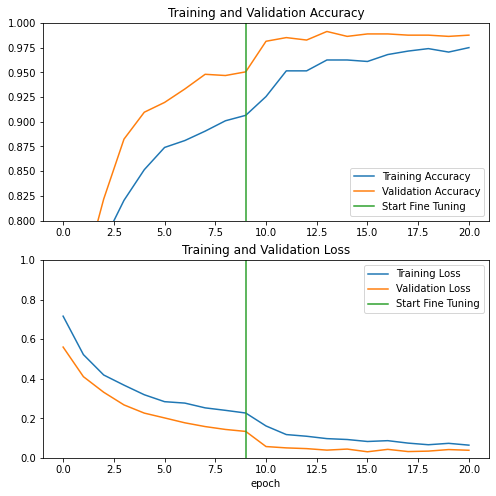

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

2/6 [=========>....................] - ETA: 0s - loss: 0.0594 - accuracy: 0.9531

3/6 [==============>...............] - ETA: 0s - loss: 0.0754 - accuracy: 0.9583

4/6 [===================>..........] - ETA: 0s - loss: 0.0950 - accuracy: 0.9531

5/6 [========================>.....] - ETA: 0s - loss: 0.0836 - accuracy: 0.9563

6/6 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9635

6/6 [==============================] - 1s 151ms/step - loss: 0.0720 - accuracy: 0.9635


Test accuracy : 0.9635416865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1]
Labels:
 [1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1]


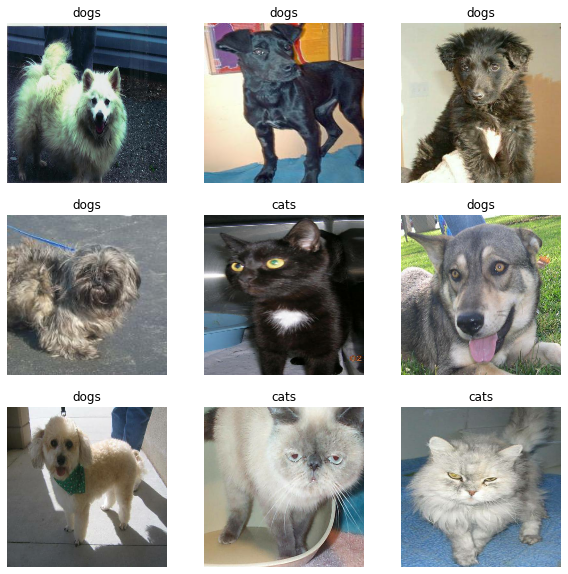

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
